<a href="https://colab.research.google.com/github/sathikaranathunga/ML-assingment/blob/main/CNN_VS_DB_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Comet ML
!pip install comet_ml --quiet
import comet_ml

# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "LtCuxFoEwG44gHY0WBLxIYbdt"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl
import os
import random
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Check that we are using a GPU, if not switch runtimes
# using Runtime > Change Runtime Type > GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    cudnn.benchmark = True
else:
    raise ValueError("GPU is not available. Change Colab runtime.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 73.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.7/473.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
 

#Datasets

In [2]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

# Create a simple check to avoid re-downloading
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)

# Instantiate a TrainingDatasetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

100%|██████████| 1.18G/1.18G [01:13<00:00, 17.1MB/s]

Opening /root/.cache/mitdeeplearning/train_face.h5


Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:


In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)
B, C, H, W = images.shape
print(B, C, H, W)  # Use uppercase variables as defined
print(f"Number of samples: {number_of_training_examples}")

100 3 64 64
Number of samples: 109914


Change the sliders to look at positive and negative training examples

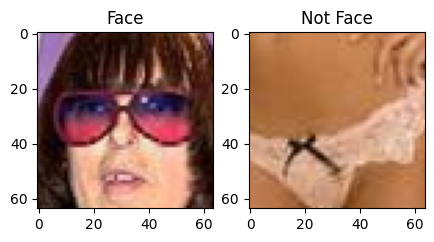

In [4]:

import matplotlib.pyplot as plt
import numpy as np
face_images = images[np.where(labels == 1)[0]].transpose(0, 2, 3, 1)
not_face_images = images[np.where(labels == 0)[0]].transpose(0, 2, 3, 1)
idx_face = 47  # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 47  # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)


#2.2 CNN for facial detecti



Define and train the CNN mo

In [5]:
import torch.nn as nn

n_filters = 12  # base number of convolutional filters
in_channels = images.shape[1]

def make_standard_classifier(n_outputs):
    """Create a standard CNN classifier."""
    # Start by first defining a convolutional block
    class ConvBlock(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
            super().__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            self.relu = nn.ReLU(inplace=True)
            self.bn = nn.BatchNorm2d(out_channels)

        def forward(self, x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)
            return x

    # now use the block to define the classifier
    model = nn.Sequential(
        ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
        ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
        nn.Flatten(),
        nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, n_outputs),
    )
    return model.to(device)

# call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

Now let's train the standard CNN!

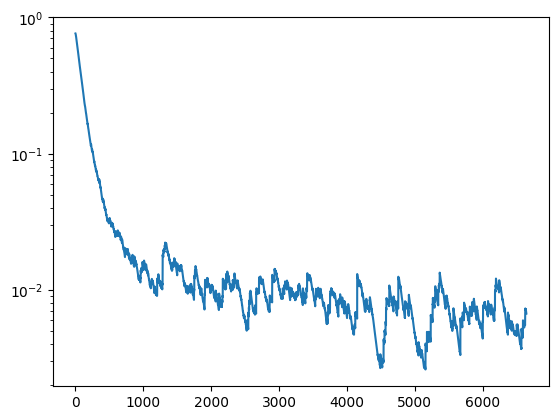

100%|██████████| 3434/3434 [00:38<00:00, 89.24it/s] 
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : important_plum_5055
COMET INFO:     url                   : https://www.comet.com/sathikaranathunga/6s191-lab2-part2-cnn/474882d03bb04eddadf3fa364f42961f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (2.0170875814073952e-07, 0.7614279985427856)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1BU6keEhG2dWYL-Gh35v8QKi8T2170I7n
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     l

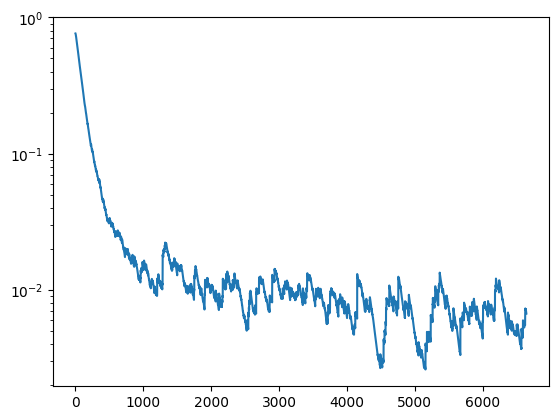

In [8]:
import comet_ml
import torch.optim as optim
import tqdm

def create_experiment(project_name, params):
    # end any prior experiments
    if "experiment" in locals():
        experiment.end()
    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()
    return experiment

# Train the standard CNN
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size=32,
    num_epochs=2,  # keep small to run faster
    learning_rate=5e-4,
)
experiment = create_experiment("6S191_Lab2_Part2_CNN", params)
optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params["learning_rate"]
)  # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)  # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale="semilogy")
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()  # clear if it exists
# set the model to train mode
standard_classifier.train()

def standard_train_step(x, y):
    x = torch.from_numpy(x).float().to(device)
    y = torch.from_numpy(y).float().to(device)
    # clear the gradients
    optimizer.zero_grad()
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = loss_fn(logits, y)
    # Backpropagation
    loss.backward()
    optimizer.step()
    return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
    for idx in tqdm.tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"])
        loss = standard_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())
        experiment.log_metric("loss", loss_value, step=step)
        step += 1
experiment.end()

Evaluate performance of the standard CNN

In [9]:
# Evaluation of standard CNN
# set the model to eval mode
standard_classifier.eval()
# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
batch_x = torch.from_numpy(batch_x).float().to(device)
batch_y = torch.from_numpy(batch_y).float().to(device)
with torch.inference_mode():
    y_pred_logits = standard_classifier(batch_x)
    y_pred_standard = torch.round(torch.sigmoid(y_pred_logits))
    acc_standard = torch.mean((batch_y == y_pred_standard).float())
    print(
        "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(
            acc_standard.item()
        )
    )

Standard CNN accuracy on (potentially biased) training set: 0.9976


Let's take a look at some sample faces in the test set

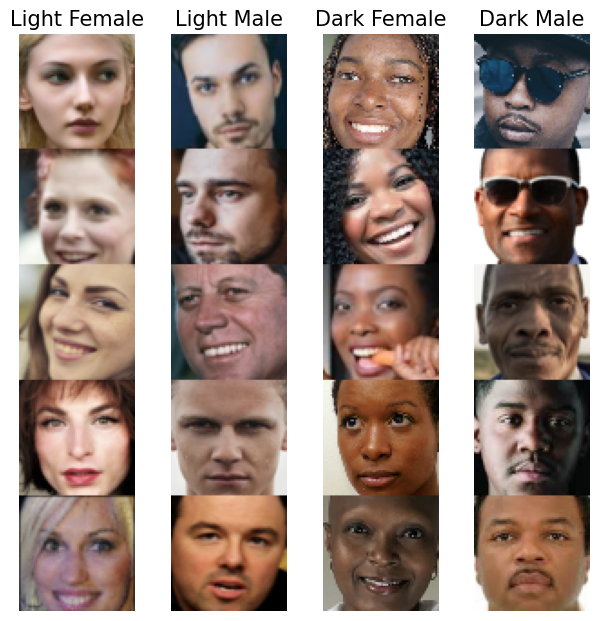

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load test dataset and plot examples
test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")

let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just


Text(0.5, 1.0, 'Standard classifier predictions')

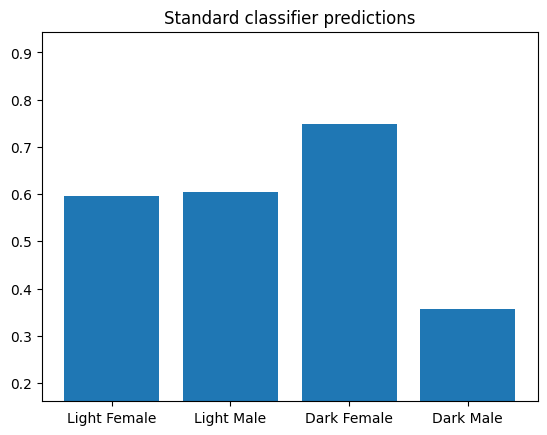

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the standard CNN on the test data
standard_classifier_probs_list = []  # store each demographic's probabilities
with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = standard_classifier(x)  # [B, 1]
        probs = torch.sigmoid(logits)  # [B, 1]
        probs = torch.squeeze(probs, dim=-1)  # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())
standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)
# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)  # shape [D]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")

#Variational autoencoder (VAE) for learning latent structure

Understanding VAEs: loss function


In [20]:
import torch

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    """Function to calculate VAE loss given:
        an input x,
        reconstructed output x_recon,
        encoded means mu,
        encoded log of standard deviation logsigma,
        weight parameter for the latent loss kl_weight
    """
    # Latent loss (KL divergence): L_{KL} = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    latent_loss = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())

    # Reconstruction loss: Mean absolute pixel-wise difference between input and reconstruction
    reconstruction_loss = torch.mean(torch.abs(x - x_recon), dim=(1, 2, 3)).sum()

    # Total VAE loss: L_{VAE} = reconstruction_loss + kl_weight * latent_loss
    vae_loss = reconstruction_loss + kl_weight * latent_loss

    return vae_loss

Understanding VAEs: reparameterization

In [21]:
import torch

def sampling(z_mean, z_logsigma):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
    # Returns
        z (tensor): sampled latent vector
    """
    # Generate random noise with the same shape as z_mean, sampled from a standard normal distribution (mean=0, std=1)
    eps = torch.randn_like(z_mean)
    # Define the reparameterization computation
    z = z_mean + torch.exp(z_logsigma) * eps
    return z

#Debiasing variational autoencoder (DB-VAE)

Defining the DB-VAE loss function

In [23]:
import torch
import torch.nn.functional as F

def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    """Loss function for DB-VAE.
    # Arguments
        x: true input x
        x_pred: reconstructed x
        y: true label (face or not face)
        y_logit: predicted labels
        mu: mean of latent distribution (Q(z|X))
        logsigma: log of standard deviation of latent distribution (Q(z|X))
    # Returns
        total_loss: DB-VAE total loss
        classification_loss: DB-VAE classification loss
    """
    # Call the VAE loss function to obtain VAE loss
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

    # Define the classification loss using binary cross-entropy with logits
    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y.float())

    # Use the training data labels to create variable face_indicator:
    # indicator that reflects which training data are images of faces
    y = y.float()
    face_indicator = (y == 1.0).float()

    # Define the DB-VAE total loss, averaging over all samples
    total_loss = torch.mean(vae_loss + face_indicator * classification_loss)

    return total_loss, classification_loss

DB-VAE architecture

In [24]:
n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables
def make_face_decoder_network(latent_dim=100, n_filters=12):
    """
    Function builds a face-decoder network.
    Args:
        latent_dim (int): the dimension of the latent representation
        n_filters (int): base number of convolutional filters
    Returns:
        decoder_model (nn.Module): the decoder network
    """
    class FaceDecoder(nn.Module):
        def __init__(self, latent_dim, n_filters):
            super(FaceDecoder, self).__init__()
            self.latent_dim = latent_dim
            self.n_filters = n_filters
            # Linear (fully connected) layer to project from latent space
            # to a 4 x 4 feature map with (6*n_filters) channels
            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 4 * 4 * 6 * n_filters),
                nn.ReLU()
            )
            # Convolutional upsampling (inverse of an encoder)
            self.deconv = nn.Sequential(
                # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
                nn.ConvTranspose2d(
                    in_channels=6 * n_filters,
                    out_channels=4 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 4n_filters, 8, 8] -> [B, 2n_filters, 16, 16]
                nn.ConvTranspose2d(
                    in_channels=4 * n_filters,
                    out_channels=2 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
                nn.ConvTranspose2d(
                    in_channels=2 * n_filters,
                    out_channels=n_filters,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, n_filters, 32, 32] -> [B, 3, 64, 64]
                nn.ConvTranspose2d(
                    in_channels=n_filters,
                    out_channels=3,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
            )
        def forward(self, z):
            """
            Forward pass of the decoder.
            Args:
                z (Tensor): Latent codes of shape [batch_size, latent_dim].
            Returns:
                Tensor of shape [batch_size, 3, 64, 64], representing
                the reconstructed images.
            """
            x = self.linear(z) # [B, 4*4*6*n_filters]
            x = x.view(-1, 6 * self.n_filters, 4, 4) # [B, 6n_filters, 4, 4]
            # Upsample through transposed convolutions
            x = self.deconv(x) # [B, 3, 64, 64]
            return x
    return FaceDecoder(latent_dim, n_filters)

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the DB-VAE

In [26]:
import torch
import torch.nn as nn

class DB_VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim
        # Define the number of outputs for the encoder.
        self.encoder = make_standard_classifier(n_outputs=2 * latent_dim + 1)
        self.decoder = make_face_decoder_network()

    # Function to feed images into encoder, encode the latent space, and output
    def encode(self, x):
        encoder_output = self.encoder(x)
        # Classification prediction
        y_logit = encoder_output[:, 0].unsqueeze(-1)
        # Latent variable distribution parameters
        z_mean = encoder_output[:, 1 : self.latent_dim + 1]
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]
        return y_logit, z_mean, z_logsigma

    # VAE reparameterization: given a mean and logsigma, sample latent variables
    def reparameterize(self, z_mean, z_logsigma):
        # Sample from standard normal distribution
        eps = torch.randn_like(z_mean)
        # Scale and shift to get z ~ N(z_mean, exp(z_logsigma))
        z = z_mean + torch.exp(z_logsigma) * eps
        return z

    # Decode the latent space and output reconstruction
    def decode(self, z):
        # Use the decoder to output the reconstruction
        reconstruction = self.decoder(z)
        return reconstruction

    # The forward function will be used to pass inputs x through the core VAE
    def forward(self, x):
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)
        # Reparameterization
        z = self.reparameterize(z_mean, z_logsigma)
        # Reconstruction
        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

    # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

dbvae = DB_VAE(latent_dim=100)

Adaptive resampling for automated debiasing with DB-VAE


In [27]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []
    # If images is NumPy, convert once outside the loop
    images_t = torch.from_numpy(images).float()
    with torch.inference_mode():
        for start in range(0, len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end]
            batch = batch.to(device).permute(0, 3, 1, 2)
            # Forward pass on this chunk only
            _, z_mean, _, _ = dbvae(batch)
            all_z_mean.append(z_mean.cpu())
    # Concatenate all partial z_mean
    z_mean_full = torch.cat(all_z_mean, dim=0) # shape [N, latent_dim]
    mu = z_mean_full.numpy() # convert to NumPy if needed
    return mu

Now, let's define the actual resampling algorithm

In [32]:

### Resampling algorithm for DB-VAE ###
"""Function that recomputes the sampling probabilities for images within a batch
based on how they distribute across the training data"""
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")
    # Run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)  # Assuming get_latent_mu is defined
    # Sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64)
    # Consider the distribution for each latent variable
    for i in range(latent_dim):  # latent_dim should be defined or passed
        latent_distribution = mu[:, i]
        # Generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(
            latent_distribution, density=True, bins=bins
        )
        # Find which latent bin every data sample falls in
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")
        # Call digitize to find which bins each data sample falls into
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # Smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        # Invert the density function
        p = 1.0 / (hist_smoothed_density[bin_idx - 1])
        # Normalize probabilities for the current latent dimension
        p = p / np.sum(p)
        # Update sampling probabilities by taking the maximum
        training_sample_p = np.maximum(training_sample_p, p)
    # Final normalization
    training_sample_p /= np.sum(training_sample_p)
    return training_sample_p


Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above
operation to re-weight the importance of particular data points as we train the model

Starting epoch 2/2
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

latent_loss = tensor(795.3069, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5672, device='cuda:0', grad_fn=<AddBackward0>)


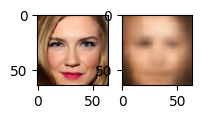

  0%|          | 9/3434 [00:00<02:26, 23.32it/s]

latent_loss = tensor(739.9514, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3400, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7100, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(770.8068, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7197, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1051, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(793.1101, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2141, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6107, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.7672, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1641, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5760, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.5598, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3975, device='cuda:0', grad_f

  0%|          | 13/3434 [00:00<02:08, 26.63it/s]

tensor(3.2952, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7093, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(783.4789, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7057, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0974, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(767.5266, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9076, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2914, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.0571, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1543, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5738, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.3534, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8524, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2666, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

  1%|          | 20/3434 [00:00<02:19, 24.55it/s]

latent_loss = tensor(852.2935, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9574, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3836, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.2870, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2288, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6519, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.0062, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3140, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7270, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(800.8191, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4763, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8767, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.9154, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4490, device='cuda:0', grad_f

  1%|          | 31/3434 [00:01<01:30, 37.63it/s]

latent_loss = tensor(814.3973, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0706, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4778, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.4918, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2197, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6420, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(756.4163, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2734, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6517, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(770.7874, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3971, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7825, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(764.9229, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8208, device='cuda:0', grad_f

  1%|          | 39/3434 [00:01<01:13, 46.34it/s]

latent_loss = tensor(851.2823, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2778, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7034, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.8514, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1699, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5908, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.2018, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0709, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4895, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.3572, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4049, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8226, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.7120, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5062, device='cuda:0', grad_f

  2%|▏         | 55/3434 [00:01<00:57, 59.15it/s]

tensor(2.9858, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4062, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(802.5660, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2984, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6997, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(761.8072, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2838, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6647, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.4929, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1536, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5634, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.8010, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2550, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6769, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

  2%|▏         | 71/3434 [00:01<00:51, 65.84it/s]

tensor(823.8781, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8946, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3065, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(800.2094, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9106, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3107, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.3884, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1320, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5372, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.3503, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3504, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7815, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.7290, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2022, device='cuda:0', grad_fn=<SumBackward

  3%|▎         | 86/3434 [00:01<00:48, 68.56it/s]

latent_loss = tensor(800.2100, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1169, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5171, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.8465, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3961, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8120, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(778.7327, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2546, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6440, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(800.7831, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3445, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7449, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.1477, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5101, device='cuda:0', grad_f

  3%|▎         | 101/3434 [00:02<00:49, 67.49it/s]

latent_loss = tensor(863.2826, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0649, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4965, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.1306, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6274, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0444, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.7803, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4264, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8603, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.9702, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4160, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8385, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.8801, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2296, device='cuda:0', grad_f

  3%|▎         | 116/3434 [00:02<00:47, 69.58it/s]

latent_loss = tensor(831.5496, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4561, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8719, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(779.2054, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5160, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9056, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(872.3030, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4692, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9053, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(906.6266, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2117, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6650, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(909.9641, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3463, device='cuda:0', grad_f

  4%|▎         | 124/3434 [00:02<00:47, 70.27it/s]

latent_loss = tensor(910.7101, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2791, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7344, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.5373, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4207, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8640, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.3895, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9493, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3870, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.2607, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3765, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7936, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.7695, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2244, device='cuda:0', grad_f

  4%|▍         | 132/3434 [00:02<00:57, 57.87it/s]

latent_loss = tensor(846.4514, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9716, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3949, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(801.2869, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0684, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4691, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(788.2620, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9632, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3573, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(762.5060, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2567, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6379, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.1637, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1108, device='cuda:0', grad_f

  4%|▍         | 139/3434 [00:02<01:11, 46.18it/s]

latent_loss = tensor(830.1506, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4602, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8752, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(791.1777, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8449, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2405, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(768.5332, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1211, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5054, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.0859, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0611, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4641, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(784.8362, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6356, device='cuda:0', grad_f

  4%|▍         | 150/3434 [00:03<01:23, 39.14it/s]

latent_loss = tensor(822.1519, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0365, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4475, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(791.5967, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0373, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4331, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.5258, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3005, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7353, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.3041, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8413, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2374, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.5618, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3982, device='cuda:0', grad_f

  5%|▍         | 165/3434 [00:03<01:02, 52.25it/s]

latent_loss = tensor(824.5126, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0690, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4812, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.3978, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5839, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0131, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(765.2751, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0427, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4254, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(784.5651, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2498, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6421, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.5277, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1343, device='cuda:0', grad_f

  5%|▌         | 172/3434 [00:03<01:00, 54.23it/s]

latent_loss = tensor(773.8894, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1759, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5628, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.7218, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3463, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7527, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.8555, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3309, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7343, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(793.3278, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1736, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5702, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.6465, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1649, device='cuda:0', grad_f

  5%|▌         | 178/3434 [00:03<01:04, 50.26it/s]

latent_loss = tensor(864.8313, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1068, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5393, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.2999, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3113, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7250, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.3123, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0006, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3968, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.5601, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1688, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6001, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.7386, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1533, device='cuda:0', grad_f

  6%|▌         | 189/3434 [00:04<01:18, 41.14it/s]

latent_loss = tensor(819.5137, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8636, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2734, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(808.5100, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9848, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3891, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.6895, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0354, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4453, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.4825, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5332, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9494, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.7411, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9696, device='cuda:0', grad_f

  6%|▌         | 201/3434 [00:04<01:14, 43.16it/s]

latent_loss = tensor(877.7273, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2331, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6720, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.1774, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0852, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5128, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.4420, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9240, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3387, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.6293, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3584, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7782, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.5453, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2592, device='cuda:0', grad_f

  6%|▋         | 217/3434 [00:04<00:57, 56.14it/s]

latent_loss = tensor(827.9047, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2882, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7021, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.4274, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0188, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4455, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.2539, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1170, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5336, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.5013, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3797, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7930, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.3354, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8539, device='cuda:0', grad_f

  7%|▋         | 232/3434 [00:04<00:52, 61.17it/s]

latent_loss = tensor(834.9737, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1064, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5239, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.3224, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0141, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4253, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.1595, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3689, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7914, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.7589, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2920, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7078, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.0500, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3560, device='cuda:0', grad_f

  7%|▋         | 240/3434 [00:04<00:49, 63.92it/s]

latent_loss = tensor(773.1378, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4784, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8650, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.9271, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2126, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6521, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.9929, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8700, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2685, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.1507, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0358, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4394, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(766.4773, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0606, device='cuda:0', grad_f

  7%|▋         | 256/3434 [00:05<00:47, 66.74it/s]

latent_loss = tensor(892.8456, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2983, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7447, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.6711, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8903, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3026, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.0436, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8709, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2814, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.4791, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0682, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4870, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.2902, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4106, device='cuda:0', grad_f

  8%|▊         | 271/3434 [00:05<00:47, 66.81it/s]

tensor(828.8629, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0591, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4736, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.0959, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0392, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4522, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.7335, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2356, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6775, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.8115, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0616, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4610, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.0182, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5136, device='cuda:0', grad_fn=<SumBackward

  8%|▊         | 286/3434 [00:05<00:46, 67.42it/s]

tensor(3.5237, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9718, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.4059, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1907, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6029, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(786.9928, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2597, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6532, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.6948, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1746, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5724, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.5240, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1306, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5353, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

  9%|▉         | 301/3434 [00:05<00:45, 68.88it/s]

latent_loss = tensor(871.8573, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3474, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7833, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(813.7889, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1587, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5656, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.7699, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3505, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7469, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.3511, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2164, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6576, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.6295, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3001, device='cuda:0', grad_f

  9%|▉         | 315/3434 [00:05<00:45, 68.06it/s]

latent_loss = tensor(775.1647, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3728, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7604, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(797.5604, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4311, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8298, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.7053, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4447, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8956, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(804.3735, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2521, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6543, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(787.8462, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9849, device='cuda:0', grad_f

 10%|▉         | 330/3434 [00:06<00:46, 66.35it/s]

latent_loss = tensor(834.2604, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8792, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2963, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.4951, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0090, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4342, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.2144, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2077, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6389, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(761.3903, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8741, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2548, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.9073, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3210, device='cuda:0', grad_f

 10%|█         | 344/3434 [00:06<00:46, 66.41it/s]

tensor(853.4286, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3098, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7366, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(873.3655, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2441, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6808, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.8922, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2408, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6317, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(799.2676, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2869, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6865, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.9308, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1327, device='cuda:0', grad_fn=<SumBackward

 10%|█         | 352/3434 [00:06<00:44, 68.61it/s]

latent_loss = tensor(820.0377, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3483, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7584, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.7033, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1455, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5573, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.5685, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2217, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6274, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.7325, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9349, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3462, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.4272, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9443, device='cuda:0', grad_f

 11%|█         | 368/3434 [00:06<00:43, 70.41it/s]

latent_loss = tensor(873.7048, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2656, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7024, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.7313, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9126, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3280, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.0177, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1122, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5257, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.5978, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2125, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6248, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.4414, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9054, device='cuda:0', grad_f

 11%|█         | 384/3434 [00:06<00:43, 70.50it/s]

latent_loss = tensor(867.5605, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2681, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7019, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.2474, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9218, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3370, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.9377, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7068, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1343, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.5228, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0417, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4835, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.6050, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7943, device='cuda:0', grad_f

 12%|█▏        | 399/3434 [00:07<00:44, 67.77it/s]

tensor(3.1712, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6192, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.9317, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4547, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8826, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.3317, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2531, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6948, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.0118, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3289, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7424, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(879.6549, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2091, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6490, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 12%|█▏        | 414/3434 [00:07<00:44, 68.21it/s]

latent_loss = tensor(804.2539, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5716, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.1327, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8141, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2316, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.3582, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3225, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7272, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.3868, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0331, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4623, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.3597, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3947, device='cuda:0', grad_f

 13%|█▎        | 430/3434 [00:07<00:42, 70.30it/s]

latent_loss = tensor(783.4512, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9694, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3611, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.7677, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4875, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8974, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.1281, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5382, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9662, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.7825, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3718, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7857, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.4107, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0929, device='cuda:0', grad_f

 13%|█▎        | 445/3434 [00:07<00:43, 69.37it/s]

latent_loss = tensor(889.2360, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5142, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(791.1396, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0473, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4429, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.5300, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9961, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3939, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(880.3580, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4474, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8876, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.0214, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9295, device='cuda:0', grad_f

 13%|█▎        | 453/3434 [00:07<00:42, 69.91it/s]

latent_loss = tensor(817.0952, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4802, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8888, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.3058, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1271, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5442, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.5530, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8502, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2880, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(803.5347, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8602, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2620, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(767.4972, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1928, device='cuda:0', grad_f

 14%|█▎        | 469/3434 [00:08<00:43, 67.98it/s]

latent_loss = tensor(827.8447, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0513, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4652, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(887.2770, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2022, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6458, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.4916, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5223, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9640, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.9044, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2838, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7108, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.3713, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8156, device='cuda:0', grad_f

 14%|█▍        | 484/3434 [00:08<00:42, 69.58it/s]

latent_loss = tensor(898.2637, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2659, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7151, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.3268, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0854, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5076, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.1732, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3135, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7566, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.6351, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9848, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4091, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.5828, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2525, device='cuda:0', grad_f

 15%|█▍        | 499/3434 [00:08<00:46, 63.20it/s]

latent_loss = tensor(871.3632, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5217, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9574, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(890.0425, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4886, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9336, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.1965, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2802, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7138, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(908.2195, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4608, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9149, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(794.2061, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8897, device='cuda:0', grad_f

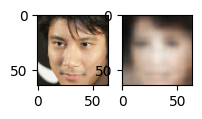

latent_loss = tensor(811.2026, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3046, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7102, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.2806, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5940, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0206, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(785.8058, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0690, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4619, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(710.0927, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9640, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3190, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(751.5585, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = 

 15%|█▍        | 506/3434 [00:09<01:33, 31.20it/s]

tensor(3.6922, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0680, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(718.9989, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1747, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5342, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(744.7014, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5998, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9722, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(708.8948, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0790, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4334, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(742.5367, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2468, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6180, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 516/3434 [00:09<01:40, 29.00it/s]

latent_loss = tensor(758.2252, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1316, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5107, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.6254, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0836, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4889, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(800.9362, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3402, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7407, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.1331, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4463, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8619, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.1595, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1036, device='cuda:0', grad_f

 15%|█▌        | 520/3434 [00:09<01:44, 27.95it/s]

latent_loss = tensor(885.4393, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3259, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7687, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.0430, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2897, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7132, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.6132, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5403, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9642, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.6819, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0780, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4959, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.0230, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2004, device='cuda:0', grad_f

 15%|█▌        | 524/3434 [00:09<01:52, 25.84it/s]

latent_loss = tensor(851.0294, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0977, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5232, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.0259, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6180, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0411, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.8942, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2248, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6287, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.3024, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0150, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4557, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.3521, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0370, device='cuda:0', grad_f

 16%|█▌        | 535/3434 [00:10<01:23, 34.78it/s]

latent_loss = tensor(840.8953, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9891, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4096, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(814.7169, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3965, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8039, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(786.0753, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1287, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5217, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(772.9269, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4108, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7972, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.1027, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1487, device='cuda:0', grad_f

 16%|█▌        | 545/3434 [00:10<01:15, 38.07it/s]

tensor(2.9188, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3443, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.8126, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2010, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6394, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.6389, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2366, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6455, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.3199, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0920, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5101, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.4069, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9827, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4244, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 16%|█▌        | 556/3434 [00:10<01:04, 44.64it/s]

latent_loss = tensor(826.9067, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8504, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2639, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.6700, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4647, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8840, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(814.7888, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2770, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6844, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(780.8306, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3111, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7015, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(785.9166, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0271, device='cuda:0', grad_f

 17%|█▋        | 567/3434 [00:10<00:59, 48.41it/s]

latent_loss = tensor(822.0029, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0059, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4169, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.3052, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2747, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7023, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.8553, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3894, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8098, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.9348, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0569, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4779, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.1150, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5683, device='cuda:0', grad_f

 17%|█▋        | 579/3434 [00:11<00:58, 48.96it/s]

latent_loss = tensor(820.2482, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2122, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6223, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.0458, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3688, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7749, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.2876, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9178, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3484, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.0125, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1730, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5940, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.5090, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0355, device='cuda:0', grad_f

 17%|█▋        | 591/3434 [00:11<00:53, 53.20it/s]

latent_loss = tensor(879.8884, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1139, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5539, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.1179, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9486, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3587, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.7632, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1243, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5332, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.3630, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2321, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6522, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.0061, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8579, device='cuda:0', grad_f

 18%|█▊        | 605/3434 [00:11<00:46, 60.35it/s]

latent_loss = tensor(877.3553, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2879, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7266, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.3083, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3676, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7882, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.1459, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9268, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3383, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.1857, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8347, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2502, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.1602, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1733, device='cuda:0', grad_f

 18%|█▊        | 621/3434 [00:11<00:42, 66.41it/s]

latent_loss = tensor(873.3413, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0088, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4455, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.7799, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5349, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(2.9523, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(775.9253, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9589, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3469, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.2648, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3421, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7862, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.3151, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1677, device='cuda:0', grad_f

 18%|█▊        | 629/3434 [00:11<00:41, 68.09it/s]

latent_loss = tensor(840.3237, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1035, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5237, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.4261, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3764, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7926, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(788.4711, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1386, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5328, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.8615, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2429, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6529, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.1051, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1093, device='cuda:0', grad_f

 19%|█▉        | 645/3434 [00:12<00:39, 69.83it/s]

latent_loss = tensor(851.1888, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8449, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2705, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(794.5114, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5114, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9086, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.9747, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1619, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5679, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.1614, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1304, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5284, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(802.9587, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9958, device='cuda:0', grad_f

 19%|█▉        | 660/3434 [00:12<00:39, 69.87it/s]

tensor(828.4719, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3060, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7203, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.1732, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2924, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7109, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(778.4619, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1317, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5209, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.2780, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3533, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7495, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(771.0287, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2947, device='cuda:0', grad_fn=<SumBackward

 20%|█▉        | 674/3434 [00:12<00:40, 67.33it/s]

tensor(2.9443, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3548, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(789.9913, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9363, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3313, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.1954, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3957, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8068, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.4524, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5353, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9551, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.7921, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1104, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5168, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 20%|██        | 689/3434 [00:12<00:40, 68.16it/s]

latent_loss = tensor(810.0535, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8391, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2442, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(808.2641, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1338, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5380, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.6521, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1717, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5935, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.7996, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4150, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8304, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.0964, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1959, device='cuda:0', grad_f

 21%|██        | 705/3434 [00:12<00:38, 70.01it/s]

latent_loss = tensor(838.5110, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0625, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4817, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.0286, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3776, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8051, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.2700, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2656, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6767, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.9812, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1250, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5715, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.9640, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1583, device='cuda:0', grad_f

 21%|██        | 720/3434 [00:13<00:38, 69.78it/s]

latent_loss = tensor(856.2119, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9316, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3597, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.4850, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2835, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7042, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.8782, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3808, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8028, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(907.1996, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2995, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7531, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.9883, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3751, device='cuda:0', grad_f

 21%|██▏       | 735/3434 [00:13<00:39, 68.61it/s]

tensor(3.0134, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4428, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.5212, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0218, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4306, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.4496, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6982, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.1279, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(813.8618, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4623, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8692, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.4824, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0380, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4408, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 22%|██▏       | 743/3434 [00:13<00:39, 68.92it/s]

latent_loss = tensor(827.2785, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4648, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8784, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.6535, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2151, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6184, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(763.3568, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9314, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3131, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(785.2828, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5890, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9816, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.9875, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4132, device='cuda:0', grad_f

 22%|██▏       | 758/3434 [00:13<00:38, 70.03it/s]

latent_loss = tensor(885.9780, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2405, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6835, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.8951, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2395, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6904, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(802.8187, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5430, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9444, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.7649, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7802, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1881, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.7874, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9727, device='cuda:0', grad_f

 23%|██▎       | 774/3434 [00:13<00:37, 71.13it/s]

latent_loss = tensor(823.8629, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5263, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9383, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.7509, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1053, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5037, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(764.0762, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8203, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2024, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(749.1351, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3952, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7698, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.0267, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2208, device='cuda:0', grad_f

 23%|██▎       | 789/3434 [00:14<00:38, 68.38it/s]

latent_loss = tensor(838.2601, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0549, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4740, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.2202, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2305, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6586, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.4742, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4913, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9175, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.4572, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1393, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5770, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.6558, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8283, device='cuda:0', grad_f

 23%|██▎       | 804/3434 [00:14<00:37, 69.39it/s]

tensor(3.0041, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3823, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.5150, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4701, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8763, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.3563, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1487, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5393, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(872.4213, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4921, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9284, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(889.5679, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0967, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5415, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 24%|██▍       | 818/3434 [00:14<00:38, 68.20it/s]

latent_loss = tensor(858.2822, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9423, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3714, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.9414, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2520, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6600, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.4940, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8140, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2462, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(897.2183, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2132, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6618, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.0687, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0655, device='cuda:0', grad_f

 24%|██▍       | 832/3434 [00:14<00:38, 67.99it/s]

latent_loss = tensor(799.2462, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6517, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0513, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(776.1876, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0266, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4146, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.6150, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8166, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2319, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(879.0201, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4331, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8726, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(927.6216, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3668, device='cuda:0', grad_f

 25%|██▍       | 846/3434 [00:14<00:39, 64.91it/s]

latent_loss = tensor(763.4869, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0362, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4179, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.3715, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9431, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3493, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(766.8890, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0444, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4279, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.8805, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4305, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8290, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(787.7520, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3827, device='cuda:0', grad_f

 25%|██▌       | 861/3434 [00:15<00:39, 65.30it/s]

latent_loss = tensor(878.8040, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2204, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6598, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.8057, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3568, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7647, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.6331, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0805, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5123, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.5483, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0687, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4915, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.2413, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0474, device='cuda:0', grad_f

 25%|██▌       | 875/3434 [00:15<00:38, 65.89it/s]

latent_loss = tensor(850.3499, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3268, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7520, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(895.5555, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0709, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5187, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.2295, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8428, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2510, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.7548, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1451, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5415, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(787.4803, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4114, device='cuda:0', grad_f

 26%|██▌       | 889/3434 [00:15<00:38, 65.98it/s]

latent_loss = tensor(825.9318, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8532, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2662, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(730.9980, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2650, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6305, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(818.9385, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8721, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2816, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(779.7028, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9693, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3592, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(818.3219, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0711, device='cuda:0', grad_f

 26%|██▌       | 897/3434 [00:15<00:38, 65.13it/s]

latent_loss = tensor(878.6459, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8827, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3220, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.1577, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2435, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6905, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.2101, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9021, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3187, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.1153, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0388, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4293, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(803.7891, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9186, device='cuda:0', grad_f

 27%|██▋       | 912/3434 [00:15<00:37, 67.55it/s]

latent_loss = tensor(833.9109, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2434, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6603, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(803.0916, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9933, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3949, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(898.6181, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2975, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7468, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(906.6077, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2773, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7306, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.5645, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0944, device='cuda:0', grad_f

 27%|██▋       | 928/3434 [00:16<00:36, 69.09it/s]

latent_loss = tensor(830.6091, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5318, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9471, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.9489, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2135, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6594, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.1487, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9774, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3809, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(927.4304, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5004, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9641, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.7999, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1091, device='cuda:0', grad_f

 27%|██▋       | 943/3434 [00:16<00:35, 69.74it/s]

latent_loss = tensor(854.3630, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2972, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7244, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.2804, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8747, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3068, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.0216, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0000, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4170, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.2394, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0304, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4616, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.1776, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2074, device='cuda:0', grad_f

 28%|██▊       | 957/3434 [00:16<00:37, 65.53it/s]

latent_loss = tensor(830.9598, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1724, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5879, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.8779, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3130, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7359, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.6185, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9263, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3531, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.6333, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1469, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5377, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(766.5798, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2452, device='cuda:0', grad_f

 28%|██▊       | 972/3434 [00:16<00:36, 67.45it/s]

latent_loss = tensor(845.9661, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2061, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6291, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.9189, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3779, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8014, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.7537, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3923, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8387, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(911.5352, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1395, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5953, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(897.5448, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1018, device='cuda:0', grad_f

 29%|██▊       | 987/3434 [00:17<00:35, 68.40it/s]

latent_loss = tensor(791.8557, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3894, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7853, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(767.1428, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0635, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4471, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.5580, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7112, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1150, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.2446, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2300, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6347, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.1464, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0429, device='cuda:0', grad_f

 29%|██▉       | 994/3434 [00:17<00:36, 66.86it/s]

latent_loss = tensor(871.8360, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9395, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3754, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(924.1646, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0850, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5471, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.8511, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9773, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3968, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(818.4826, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2470, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6563, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.0008, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1881, device='cuda:0', grad_f

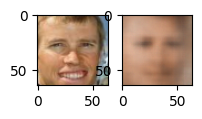

 29%|██▉       | 1001/3434 [00:17<00:55, 43.61it/s]

latent_loss = tensor(856.0828, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0129, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4410, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(908.5742, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0976, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5519, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.9222, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9000, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3239, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.9917, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9606, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3791, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.0236, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6895, device='cuda:0', grad_f

 29%|██▉       | 1007/3434 [00:17<01:06, 36.45it/s]

tensor(2.9066, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3058, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(783.5492, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0846, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4764, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.6581, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9399, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3362, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(790.1062, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9764, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3715, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.5559, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2811, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7109, device='cuda:0', grad_fn=<AddBackward0>)


 30%|██▉       | 1016/3434 [00:18<01:21, 29.65it/s]

latent_loss = tensor(833.6179, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8093, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2261, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.6852, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2893, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6886, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.7432, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1046, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5220, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.1772, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7677, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1713, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(887.6332, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0873, device='cuda:0', grad_f

 30%|██▉       | 1027/3434 [00:18<01:01, 39.05it/s]

latent_loss = tensor(931.1384, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0264, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4920, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.5470, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9786, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4244, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.0650, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2609, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7114, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.0028, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2102, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6367, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(885.2817, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7400, device='cuda:0', grad_f

 30%|███       | 1041/3434 [00:18<00:47, 50.08it/s]

latent_loss = tensor(825.3186, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5596, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(2.9722, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.5353, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9798, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3846, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.8762, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0763, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4978, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.5443, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2961, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7304, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.3182, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9473, device='cuda:0', grad_f

 31%|███       | 1055/3434 [00:18<00:41, 56.67it/s]

latent_loss = tensor(782.4209, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1170, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5082, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(787.2930, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5600, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9537, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.0176, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1083, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5253, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.3738, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4237, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8229, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.4842, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2190, device='cuda:0', grad_f

 31%|███       | 1063/3434 [00:18<00:39, 60.74it/s]

tensor(3.3479, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.8395, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2604, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6823, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(895.8728, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9913, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4392, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.3102, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9139, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3476, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(921.4172, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3203, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7810, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.1973, device='cuda:0', grad_fn=<MulBackward0>)
reco

 31%|███▏      | 1079/3434 [00:19<00:35, 66.29it/s]

latent_loss = tensor(826.7497, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0549, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4682, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.5610, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3203, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7540, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.8287, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1433, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5817, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.0055, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0400, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4740, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.4932, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6932, device='cuda:0', grad_f

 32%|███▏      | 1093/3434 [00:19<00:35, 66.48it/s]

latent_loss = tensor(773.8533, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6229, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0098, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(750.3347, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2842, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6594, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(720.9393, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2468, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6073, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(743.6735, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0679, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4397, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(778.5404, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1995, device='cuda:0', grad_f

 32%|███▏      | 1107/3434 [00:19<00:35, 66.47it/s]

latent_loss = tensor(859.8798, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0307, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4607, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.9136, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1400, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5825, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(921.0312, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2347, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6953, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(944.8280, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0196, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4920, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.4987, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2067, device='cuda:0', grad_f

 33%|███▎      | 1121/3434 [00:19<00:35, 65.77it/s]

latent_loss = tensor(815.6322, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3442, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7520, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(772.8842, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1623, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5488, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.1686, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3842, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7867, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.3289, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9831, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4273, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.0293, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1425, device='cuda:0', grad_f

 33%|███▎      | 1136/3434 [00:19<00:34, 67.50it/s]

latent_loss = tensor(843.8894, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4285, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8505, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.3414, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2477, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6674, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.3729, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3710, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8067, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.7014, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1541, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5839, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.7205, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3202, device='cuda:0', grad_f

 33%|███▎      | 1150/3434 [00:20<00:33, 67.56it/s]

latent_loss = tensor(774.7836, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3401, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7275, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.7533, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1426, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5595, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.8107, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1183, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5262, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(910.5950, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4881, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9434, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.7147, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0660, device='cuda:0', grad_f

 34%|███▍      | 1164/3434 [00:20<00:33, 67.20it/s]

latent_loss = tensor(922.5297, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4363, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8976, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.6581, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7405, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1684, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(799.4451, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4285, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8282, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.7539, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0983, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4962, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.2391, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3937, device='cuda:0', grad_f

 34%|███▍      | 1179/3434 [00:20<00:33, 67.92it/s]

tensor(3.4444, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.3348, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1879, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6111, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(790.3876, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2448, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6400, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(813.9388, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3414, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7483, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.6488, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3854, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8092, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.7067, device='cuda:0', grad_fn=<MulBackward0>)
reco

 35%|███▍      | 1193/3434 [00:20<00:33, 66.02it/s]

latent_loss = tensor(876.6115, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6528, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0911, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(885.0861, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2250, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6676, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.1061, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9809, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4194, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.2802, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4337, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8518, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.4844, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1078, device='cuda:0', grad_f

 35%|███▌      | 1208/3434 [00:21<00:32, 67.93it/s]

latent_loss = tensor(825.3302, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4263, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8390, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(903.5516, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0548, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5065, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(808.6943, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8099, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2143, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.7634, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1687, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6110, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.0828, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1250, device='cuda:0', grad_f

 36%|███▌      | 1222/3434 [00:21<00:33, 65.16it/s]

tensor(2.9775, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3984, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.2666, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8453, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2789, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.8630, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4196, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8515, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.1435, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0141, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4327, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(764.5555, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7535, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1357, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 36%|███▌      | 1235/3434 [00:21<00:38, 56.72it/s]

latent_loss = tensor(798.1002, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1908, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5898, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.2876, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0947, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5214, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.8135, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3039, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7368, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.2825, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2767, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6934, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.7250, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1111, device='cuda:0', grad_f

 36%|███▌      | 1241/3434 [00:21<00:39, 55.47it/s]

latent_loss = tensor(845.0988, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1905, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6130, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.5269, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9918, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4131, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.2056, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0005, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4091, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.8127, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9700, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3734, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(872.7048, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9849, device='cuda:0', grad_f

 36%|███▋      | 1253/3434 [00:21<00:41, 52.91it/s]

latent_loss = tensor(834.8562, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3965, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8139, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.2023, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1179, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5435, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.0350, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9638, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3839, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.1641, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9791, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3972, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.2710, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5656, device='cuda:0', grad_f

 37%|███▋      | 1265/3434 [00:22<00:40, 53.96it/s]

latent_loss = tensor(856.6174, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9097, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3380, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.3476, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1617, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5864, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(804.8712, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1885, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5909, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.1255, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0112, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4293, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.5963, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2425, device='cuda:0', grad_f

 37%|███▋      | 1277/3434 [00:22<00:40, 52.82it/s]

latent_loss = tensor(859.6693, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0630, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4928, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.0446, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0437, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4597, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(758.3802, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9803, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3595, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(803.9604, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8137, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2157, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(784.8119, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5710, device='cuda:0', grad_f

 38%|███▊      | 1289/3434 [00:22<00:40, 53.38it/s]

latent_loss = tensor(848.3844, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9573, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3815, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.5042, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0628, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4765, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.6531, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9981, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4019, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.5029, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0531, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4749, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.3794, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1681, device='cuda:0', grad_f

 38%|███▊      | 1301/3434 [00:22<00:39, 53.82it/s]

latent_loss = tensor(889.3447, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2562, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7009, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(922.4170, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1562, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6175, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.0309, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0096, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4356, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.5373, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9919, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4256, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.8000, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2261, device='cuda:0', grad_f

 38%|███▊      | 1307/3434 [00:22<00:40, 52.07it/s]

latent_loss = tensor(845.3408, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2714, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6941, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.7657, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2945, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6979, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(813.1973, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1037, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5103, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.9523, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3561, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7851, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.9789, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3353, device='cuda:0', grad_f

 38%|███▊      | 1319/3434 [00:23<00:43, 48.50it/s]

latent_loss = tensor(833.5446, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8244, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2411, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.0794, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1993, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6424, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.1315, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8185, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2390, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.7793, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8746, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2985, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(900.1682, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9866, device='cuda:0', grad_f

 39%|███▉      | 1331/3434 [00:23<00:41, 50.43it/s]

latent_loss = tensor(920.2590, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3375, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7976, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.4656, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9088, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3380, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.1138, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8660, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2976, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.5905, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2482, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6700, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.8016, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1173, device='cuda:0', grad_f

 39%|███▉      | 1343/3434 [00:23<00:40, 51.59it/s]

latent_loss = tensor(812.6069, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3223, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7286, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.8226, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4079, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8113, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.8811, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3889, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8178, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.7672, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2958, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7307, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.5162, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1023, device='cuda:0', grad_f

 39%|███▉      | 1354/3434 [00:23<00:42, 48.76it/s]

latent_loss = tensor(841.6810, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2974, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7182, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.5106, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4519, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8802, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.0262, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9926, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4172, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(870.6102, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1387, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5740, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.5079, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4128, device='cuda:0', grad_f

 40%|███▉      | 1366/3434 [00:24<00:38, 53.76it/s]

latent_loss = tensor(866.6562, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9182, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3515, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.7573, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.7617, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.1761, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.2819, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0625, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5131, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(789.7129, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0551, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4499, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.3392, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1444, device='cuda:0', grad_f

 40%|████      | 1380/3434 [00:24<00:33, 60.61it/s]

tensor(854.6096, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3419, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7692, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.7028, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6704, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0942, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.6791, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7077, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1266, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.0366, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0544, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4799, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.9858, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0489, device='cuda:0', grad_fn=<SumBackward

 41%|████      | 1395/3434 [00:24<00:30, 65.93it/s]

latent_loss = tensor(912.5838, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4002, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8564, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.5515, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0373, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4645, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.0060, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0183, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4353, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.7007, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1802, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5975, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.4186, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8082, device='cuda:0', grad_f

 41%|████      | 1409/3434 [00:24<00:30, 66.77it/s]

latent_loss = tensor(828.9031, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2693, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6837, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.3717, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0627, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4919, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.3342, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0270, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4582, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.2536, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9345, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3756, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.1484, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2649, device='cuda:0', grad_f

 41%|████      | 1416/3434 [00:24<00:31, 64.02it/s]

latent_loss = tensor(814.9680, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2332, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6407, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.2139, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0454, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4895, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.6166, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8151, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2129, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.3358, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9733, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3840, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.1700, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0084, device='cuda:0', grad_f

 42%|████▏     | 1431/3434 [00:25<00:30, 64.72it/s]

tensor(3.3405, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.3282, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0295, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4472, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.6570, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0734, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4892, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.9117, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0592, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4921, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(885.5562, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2498, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6925, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.8622, device='cuda:0', grad_fn=<MulBackward0>)
reco

 42%|████▏     | 1446/3434 [00:25<00:29, 67.47it/s]

latent_loss = tensor(899.8879, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8941, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3440, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.6028, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0827, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5075, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(790.8303, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0729, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4683, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.3609, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8606, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2748, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(803.3334, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2966, device='cuda:0', grad_f

 43%|████▎     | 1461/3434 [00:25<00:29, 67.94it/s]

latent_loss = tensor(844.4107, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8283, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2505, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(870.5198, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3350, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7703, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(953.8528, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3990, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8759, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(945.5772, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1726, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6454, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.2900, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0795, device='cuda:0', grad_f

 43%|████▎     | 1476/3434 [00:25<00:28, 68.74it/s]

tensor(2.9195, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3265, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.4425, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9164, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3377, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(783.9740, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2841, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6761, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.0323, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4456, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8612, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(804.0894, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0973, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4994, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 43%|████▎     | 1491/3434 [00:25<00:28, 67.34it/s]

latent_loss = tensor(868.4200, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2694, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7036, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.7240, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7298, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1587, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.0783, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8703, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2949, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(898.0005, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1152, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5642, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.3286, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0447, device='cuda:0', grad_f

 44%|████▎     | 1498/3434 [00:26<00:28, 67.49it/s]

latent_loss = tensor(831.4922, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1484, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5641, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(930.2911, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4206, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8858, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.0065, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2525, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6865, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.0673, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1224, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5384, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.6086, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1306, device='cuda:0', grad_f

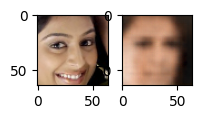

 44%|████▍     | 1505/3434 [00:26<00:50, 38.03it/s]

latent_loss = tensor(771.6165, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0512, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4370, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.2438, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2781, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7012, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.5920, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9719, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4107, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.1331, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9733, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3899, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.0651, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2494, device='cuda:0', grad_f

 44%|████▍     | 1511/3434 [00:26<01:00, 31.67it/s]

latent_loss = tensor(827.0558, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0902, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5037, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.0513, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3089, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7244, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.0676, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1281, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5612, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.9078, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0858, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5137, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(897.4583, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0151, device='cuda:0', grad_f

 44%|████▍     | 1516/3434 [00:26<01:06, 28.92it/s]

latent_loss = tensor(814.2478, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3138, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7209, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.2356, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9864, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4201, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.0975, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2761, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7151, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.5695, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9327, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3660, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(896.1910, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0641, device='cuda:0', grad_f

 44%|████▍     | 1528/3434 [00:27<00:49, 38.66it/s]

latent_loss = tensor(904.8357, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1015, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5539, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.0056, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9905, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4285, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.1547, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9787, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4108, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.6385, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3160, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7618, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.3516, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9258, device='cuda:0', grad_f

 45%|████▍     | 1541/3434 [00:27<00:39, 47.98it/s]

latent_loss = tensor(878.0421, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4258, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8648, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(761.0671, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9038, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2843, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.9039, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2957, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7256, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.3823, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1759, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5891, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.1674, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2043, device='cuda:0', grad_f

 45%|████▌     | 1555/3434 [00:27<00:33, 56.30it/s]

latent_loss = tensor(864.6605, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9592, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3916, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.9980, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2343, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6608, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.1964, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8645, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2696, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.1677, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0610, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4786, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.0045, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2163, device='cuda:0', grad_f

 46%|████▌     | 1569/3434 [00:27<00:29, 62.39it/s]

latent_loss = tensor(875.0176, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3604, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7979, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.9579, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1788, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6162, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.5660, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9992, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4425, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.0763, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5939, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0224, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.8157, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0191, device='cuda:0', grad_f

 46%|████▌     | 1583/3434 [00:27<00:28, 64.66it/s]

tensor(846.2719, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8024, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2255, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.0186, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9787, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4112, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.1770, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.7220, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.1500, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.0134, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3219, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7384, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(797.9705, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2876, device='cuda:0', grad_fn=<SumBackward

 47%|████▋     | 1597/3434 [00:28<00:29, 62.29it/s]

latent_loss = tensor(862.7845, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1414, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5728, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.7747, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1037, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5136, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.9771, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9137, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3122, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.0295, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3878, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8213, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.1716, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0919, device='cuda:0', grad_f

 47%|████▋     | 1611/3434 [00:28<00:28, 63.83it/s]

tensor(818.6555, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4612, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8705, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.8003, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0086, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4235, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.3713, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1782, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6164, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.1404, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0685, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4770, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.7253, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9855, device='cuda:0', grad_fn=<SumBackward

 47%|████▋     | 1626/3434 [00:28<00:27, 66.85it/s]

latent_loss = tensor(777.2823, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3406, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7292, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(764.8336, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1309, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5133, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(785.0162, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2795, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6720, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(797.9577, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8390, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2380, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(761.5569, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1919, device='cuda:0', grad_f

 48%|████▊     | 1640/3434 [00:28<00:27, 66.17it/s]

latent_loss = tensor(817.6916, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6886, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0974, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.9563, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2642, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6747, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.0903, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9272, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3427, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.1827, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9036, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3147, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.0084, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1273, device='cuda:0', grad_f

 48%|████▊     | 1654/3434 [00:29<00:26, 66.48it/s]

tensor(3.3415, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.2454, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1200, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5662, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(961.9211, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4816, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9625, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.5961, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8967, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3285, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.6495, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3132, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7365, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.2972, device='cuda:0', grad_fn=<MulBackward0>)
reco

 48%|████▊     | 1661/3434 [00:29<00:26, 66.88it/s]

latent_loss = tensor(828.1588, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7983, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2124, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.8989, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1075, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5394, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.0455, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0417, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4743, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.9706, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1108, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5268, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(900.1289, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1882, device='cuda:0', grad_f

 49%|████▉     | 1676/3434 [00:29<00:27, 64.59it/s]

latent_loss = tensor(899.7328, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3267, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7766, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.8528, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0631, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4946, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.3546, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2368, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6700, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.2449, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9430, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3671, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.0002, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1327, device='cuda:0', grad_f

 49%|████▉     | 1691/3434 [00:29<00:26, 66.68it/s]

latent_loss = tensor(814.4158, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4454, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8526, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(799.7687, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0451, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4450, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.3430, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0854, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5146, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.0002, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8332, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2537, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.8905, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0927, device='cuda:0', grad_f

 49%|████▉     | 1698/3434 [00:29<00:29, 58.88it/s]

latent_loss = tensor(766.1837, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7414, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1245, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.4198, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1389, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5491, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.9772, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1402, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5762, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(907.7439, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9180, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3719, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.4390, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0414, device='cuda:0', grad_f

 50%|████▉     | 1705/3434 [00:30<00:41, 41.44it/s]

tensor(808.8212, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8237, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2281, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.9105, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1412, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5601, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.6381, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4041, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8149, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.8813, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8595, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2650, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.4883, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4840, device='cuda:0', grad_fn=<SumBackward

 50%|████▉     | 1710/3434 [00:30<00:43, 39.53it/s]

latent_loss = tensor(885.5372, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9819, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4246, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.0933, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0972, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5238, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.1476, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5899, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0275, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.3273, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9542, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3884, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.6887, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2544, device='cuda:0', grad_f

 50%|█████     | 1722/3434 [00:30<00:38, 44.80it/s]

latent_loss = tensor(833.6024, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8956, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3124, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.8918, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9284, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3474, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.7957, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1965, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6349, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.0425, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0756, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5126, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(900.4859, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2033, device='cuda:0', grad_f

 51%|█████     | 1736/3434 [00:30<00:31, 54.73it/s]

latent_loss = tensor(795.3013, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2337, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6314, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.7767, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1462, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5615, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.1232, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8761, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2906, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.5221, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9393, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3580, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(803.8885, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7751, device='cuda:0', grad_f

 51%|█████     | 1750/3434 [00:30<00:27, 60.54it/s]

latent_loss = tensor(819.8922, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7957, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2056, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.4916, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2741, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7053, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(909.4730, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6181, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0728, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(902.3907, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9834, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4346, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.5640, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1518, device='cuda:0', grad_f

 51%|█████     | 1757/3434 [00:30<00:26, 62.23it/s]

latent_loss = tensor(806.8494, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2753, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6787, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.8030, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0381, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4825, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.6317, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3188, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7596, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.0610, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0357, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4472, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(907.1224, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4361, device='cuda:0', grad_f

 52%|█████▏    | 1769/3434 [00:31<01:00, 27.33it/s]

latent_loss = tensor(851.6204, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0515, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4773, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.5720, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7980, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2133, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.7113, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9508, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3737, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.3649, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1495, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5682, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(818.2097, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8444, device='cuda:0', grad_f

 52%|█████▏    | 1774/3434 [00:31<00:58, 28.36it/s]

latent_loss = tensor(848.8861, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6385, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0629, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.6047, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2002, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6260, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.7209, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3411, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7724, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.6376, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1494, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5628, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.4065, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8095, device='cuda:0', grad_f

 52%|█████▏    | 1788/3434 [00:32<00:39, 41.71it/s]

latent_loss = tensor(888.1522, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0537, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4978, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.4051, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2766, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7063, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.8699, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7721, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1900, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.5867, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0299, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4647, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.7838, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6213, device='cuda:0', grad_f

 52%|█████▏    | 1801/3434 [00:32<00:32, 50.09it/s]

latent_loss = tensor(852.5053, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4547, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8810, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.7034, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3490, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7798, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.5607, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9958, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4271, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.6262, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1425, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5598, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.5396, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5645, device='cuda:0', grad_f

 53%|█████▎    | 1816/3434 [00:32<00:27, 58.44it/s]

latent_loss = tensor(809.6898, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9751, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3799, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.7197, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2279, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6598, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.6525, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0492, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4925, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.0579, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1434, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5689, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.7969, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2105, device='cuda:0', grad_f

 53%|█████▎    | 1831/3434 [00:32<00:25, 63.76it/s]

latent_loss = tensor(887.0505, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3150, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7585, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.6207, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2716, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6844, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.8385, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0638, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5062, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(909.1053, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8919, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3464, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.9747, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7539, device='cuda:0', grad_f

 54%|█████▎    | 1845/3434 [00:32<00:24, 65.77it/s]

latent_loss = tensor(849.6284, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1787, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6035, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.4788, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1752, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5969, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.7887, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0744, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4978, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.0323, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8068, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2478, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(910.0779, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0003, device='cuda:0', grad_f

 54%|█████▍    | 1859/3434 [00:33<00:23, 67.04it/s]

latent_loss = tensor(860.0660, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3416, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7716, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.7786, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8685, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2934, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.0858, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9582, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3727, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.6712, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9452, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3690, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(767.6176, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8329, device='cuda:0', grad_f

 55%|█████▍    | 1873/3434 [00:33<00:23, 65.42it/s]

latent_loss = tensor(826.8961, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9965, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4100, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.6340, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2845, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7043, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.6763, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1699, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5808, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.4175, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9421, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3678, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.4022, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1404, device='cuda:0', grad_f

 55%|█████▍    | 1888/3434 [00:33<00:23, 66.67it/s]

latent_loss = tensor(875.1021, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9175, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3550, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.4331, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0636, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4828, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.3591, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9980, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4436, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(959.1897, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2434, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7230, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.5349, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8788, device='cuda:0', grad_f

 55%|█████▌    | 1903/3434 [00:33<00:22, 68.37it/s]

latent_loss = tensor(849.5490, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0471, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4718, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(814.3390, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0279, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4350, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(793.0754, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8940, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2905, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.9526, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2924, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7193, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(770.2714, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9181, device='cuda:0', grad_f

 56%|█████▌    | 1910/3434 [00:33<00:23, 65.07it/s]

latent_loss = tensor(847.0457, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1867, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6102, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.5929, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1733, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5946, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.2560, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8373, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2779, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.6628, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9251, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3370, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.7462, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1923, device='cuda:0', grad_f

 56%|█████▌    | 1924/3434 [00:34<00:27, 55.62it/s]

latent_loss = tensor(816.7555, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1027, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5110, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.6990, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7923, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2137, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.6294, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2744, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7042, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(880.7760, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0120, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4523, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.6598, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3256, device='cuda:0', grad_f

 56%|█████▋    | 1936/3434 [00:34<00:29, 51.20it/s]

latent_loss = tensor(819.1370, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4058, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8154, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.0396, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3547, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8012, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.0099, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2680, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6890, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(890.6489, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2160, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6614, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.0367, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1516, device='cuda:0', grad_f

 57%|█████▋    | 1948/3434 [00:34<00:27, 53.07it/s]

tensor(802.9548, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2190, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6205, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(791.3168, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3166, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7123, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(787.5785, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1130, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5067, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(763.1816, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9416, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3232, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(814.1046, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0908, device='cuda:0', grad_fn=<SumBackward

 57%|█████▋    | 1960/3434 [00:34<00:27, 54.04it/s]

latent_loss = tensor(895.6593, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8312, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2790, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(911.2430, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3251, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(937.9232, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8724, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3413, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.4994, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5627, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9889, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.0299, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9014, device='cuda:0', grad_f

 57%|█████▋    | 1966/3434 [00:35<00:28, 52.14it/s]

latent_loss = tensor(814.2245, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9358, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3429, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.1620, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0264, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4435, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.0930, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5185, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9161, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.7568, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1890, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6284, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(879.9026, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9394, device='cuda:0', grad_f

 58%|█████▊    | 1978/3434 [00:35<00:28, 51.49it/s]

latent_loss = tensor(852.8269, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0590, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4854, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.0189, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9048, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3318, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.3528, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0694, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4870, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(899.8098, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8232, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2731, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.6498, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7613, device='cuda:0', grad_f

 58%|█████▊    | 1990/3434 [00:35<00:28, 50.10it/s]

latent_loss = tensor(893.0636, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1798, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6263, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.1459, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2213, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6554, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(873.8481, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9386, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3755, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(887.6448, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2154, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6592, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(923.0742, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2439, device='cuda:0', grad_f

 58%|█████▊    | 1996/3434 [00:35<00:27, 52.05it/s]

latent_loss = tensor(910.8981, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0789, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5343, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.4071, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2345, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6632, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.0175, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3763, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7843, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.7402, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1767, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6031, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.0718, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0102, device='cuda:0', grad_f

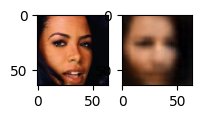

 58%|█████▊    | 2002/3434 [00:35<00:46, 30.93it/s]

latent_loss = tensor(795.1919, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7842, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1818, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.7442, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3194, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7482, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.0787, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9043, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3154, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.1094, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1540, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5870, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 2007/3434 [00:36<00:50, 28.34it/s]

latent_loss = tensor(845.9036, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9234, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3463, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.6113, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2144, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6392, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(906.8478, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9829, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4364, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.0310, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1180, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5565, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(899.3279, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2194, device='cuda:0', grad_f

 59%|█████▊    | 2015/3434 [00:36<00:48, 29.09it/s]

latent_loss = tensor(863.1052, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0094, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4410, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.8693, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5220, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9519, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.2769, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2919, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7085, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.8605, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9676, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3955, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.2294, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0332, device='cuda:0', grad_f

 59%|█████▉    | 2025/3434 [00:36<00:38, 36.17it/s]

latent_loss = tensor(791.6752, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2884, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6843, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(890.7416, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0440, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4894, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.1984, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4771, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(791.4963, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8722, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2679, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(914.1733, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3413, device='cuda:0', grad_f

 59%|█████▉    | 2040/3434 [00:36<00:27, 51.59it/s]

latent_loss = tensor(857.7109, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2109, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6397, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.4658, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9086, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3309, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.6267, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1139, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5192, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.8599, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7908, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2217, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.9828, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1566, device='cuda:0', grad_f

 60%|█████▉    | 2054/3434 [00:37<00:23, 58.63it/s]

tensor(3.3124, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(777.6168, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9976, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3864, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.1956, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2171, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6372, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(770.0763, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9890, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3740, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.0752, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9768, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4109, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.1564, device='cuda:0', grad_fn=<MulBackward0>)
reco

 60%|██████    | 2068/3434 [00:37<00:22, 61.54it/s]

latent_loss = tensor(825.2722, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0831, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4958, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.9611, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2713, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7072, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.7349, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1740, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5918, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.0724, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7544, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1700, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(808.8981, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9936, device='cuda:0', grad_f

 61%|██████    | 2083/3434 [00:37<00:20, 65.84it/s]

latent_loss = tensor(853.2866, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8845, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3111, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.1259, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2959, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7235, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.3494, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3879, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8086, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(914.7000, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9869, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4443, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.2828, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3539, device='cuda:0', grad_f

 61%|██████    | 2097/3434 [00:37<00:20, 64.92it/s]

latent_loss = tensor(868.8751, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1081, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5425, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.0992, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9458, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3519, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.4774, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3334, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7631, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.0356, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2389, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6444, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.1199, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0315, device='cuda:0', grad_f

 62%|██████▏   | 2112/3434 [00:38<00:19, 66.86it/s]

latent_loss = tensor(799.3668, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8304, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2301, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.7512, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1311, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5540, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.7937, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0654, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4753, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.2512, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1053, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5274, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.7929, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9739, device='cuda:0', grad_f

 62%|██████▏   | 2126/3434 [00:38<00:20, 63.59it/s]

latent_loss = tensor(860.4988, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8690, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2992, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.7016, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8943, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3147, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.2183, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0922, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5128, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.2383, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3448, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7864, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.6337, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9388, device='cuda:0', grad_f

 62%|██████▏   | 2140/3434 [00:38<00:19, 64.93it/s]

latent_loss = tensor(811.0634, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8038, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2093, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.7386, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2992, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7401, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(915.6760, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9426, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4005, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(951.2295, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1258, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6014, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.4901, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0666, device='cuda:0', grad_f

 63%|██████▎   | 2155/3434 [00:38<00:20, 63.47it/s]

latent_loss = tensor(849.7825, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0122, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4371, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.3050, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2745, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6826, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(801.0100, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9346, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3351, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.9059, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6103, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0327, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.6334, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1062, device='cuda:0', grad_f

 63%|██████▎   | 2162/3434 [00:39<00:34, 36.64it/s]

latent_loss = tensor(857.2010, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2355, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6641, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.6439, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8621, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2799, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.5587, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1053, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5435, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.6047, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3164, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7382, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.6351, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = 

 63%|██████▎   | 2168/3434 [00:39<00:37, 34.17it/s]

tensor(3.1370, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5788, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.5248, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9272, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3504, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.4781, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8518, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2671, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.4581, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1200, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5387, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.0273, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3268, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7698, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 63%|██████▎   | 2178/3434 [00:39<00:34, 36.91it/s]

latent_loss = tensor(862.6298, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8413, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2726, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.4872, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2099, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6162, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.8691, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7974, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2483, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(880.2455, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0063, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4464, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.5793, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1561, device='cuda:0', grad_f

 64%|██████▍   | 2192/3434 [00:39<00:25, 48.43it/s]

tensor(843.7457, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1224, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5442, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(804.1879, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3994, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8015, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.0544, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9726, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4231, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.6777, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1795, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5918, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.9355, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2153, device='cuda:0', grad_fn=<SumBackward

 64%|██████▍   | 2206/3434 [00:39<00:22, 55.54it/s]

tensor(3.7384, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.3972, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9236, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3443, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.9319, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1088, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5377, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.4502, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2341, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6643, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.8615, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0904, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5378, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.4503, device='cuda:0', grad_fn=<MulBackward0>)
reco

 65%|██████▍   | 2220/3434 [00:40<00:20, 58.05it/s]

latent_loss = tensor(857.5293, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2940, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7228, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.8542, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2097, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6301, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(745.8218, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7047, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0777, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.3217, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7965, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1991, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.2855, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9394, device='cuda:0', grad_f

 65%|██████▌   | 2234/3434 [00:40<00:19, 62.24it/s]

tensor(3.1031, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5159, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(886.0177, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1870, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6300, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(898.8052, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0308, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4802, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(897.7323, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9845, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4334, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.1824, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9688, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3649, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 65%|██████▌   | 2248/3434 [00:40<00:18, 65.24it/s]

latent_loss = tensor(861.6774, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7137, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1445, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.2238, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8394, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2700, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.9463, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9531, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3681, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.3201, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9926, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4312, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.6812, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8181, device='cuda:0', grad_f

 66%|██████▌   | 2255/3434 [00:40<00:17, 65.73it/s]

latent_loss = tensor(820.4991, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.6186, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0289, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.1191, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0151, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4397, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.4136, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7101, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1258, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.7897, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1607, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5841, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(781.3168, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1751, device='cuda:0', grad_f

 66%|██████▌   | 2269/3434 [00:40<00:18, 63.02it/s]

tensor(3.3413, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.0758, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6796, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1046, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.1505, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8703, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3023, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.3356, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6725, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0957, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.0603, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1672, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5858, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(912.8793, device='cuda:0', grad_fn=<MulBackward0>)
reco

 66%|██████▋   | 2283/3434 [00:41<00:17, 64.68it/s]

latent_loss = tensor(913.1792, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0864, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5430, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(904.6677, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0005, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4528, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(789.6965, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3964, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7912, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(905.5607, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3057, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7584, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(801.0475, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9972, device='cuda:0', grad_f

 67%|██████▋   | 2297/3434 [00:41<00:17, 65.90it/s]

latent_loss = tensor(837.9152, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3256, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7446, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.1875, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2744, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7215, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.4194, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1629, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5817, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(889.9113, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1419, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5869, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.7805, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3752, device='cuda:0', grad_f

 67%|██████▋   | 2311/3434 [00:41<00:16, 66.54it/s]

latent_loss = tensor(833.4060, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7036, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1203, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.8892, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1678, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5847, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.9067, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0447, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4702, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.1034, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0575, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4765, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.6019, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0975, device='cuda:0', grad_f

 68%|██████▊   | 2325/3434 [00:41<00:16, 67.14it/s]

latent_loss = tensor(851.6396, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8017, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2276, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(905.0938, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8243, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2769, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.9651, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8285, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2399, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(904.7303, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0181, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4705, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.4670, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8077, device='cuda:0', grad_f

 68%|██████▊   | 2340/3434 [00:42<00:16, 66.12it/s]

latent_loss = tensor(867.2935, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8463, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2799, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(756.2455, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0368, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4149, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.5951, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1932, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6235, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.6244, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1862, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6091, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.7372, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9255, device='cuda:0', grad_f

 69%|██████▊   | 2354/3434 [00:42<00:16, 65.46it/s]

latent_loss = tensor(848.0052, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1272, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5512, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.5431, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1579, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5751, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.7046, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3238, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7567, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.6617, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9400, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3674, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.4996, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1883, device='cuda:0', grad_f

 69%|██████▉   | 2368/3434 [00:42<00:15, 66.77it/s]

tensor(3.1161, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(926.1221, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7855, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2485, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.8390, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8047, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2442, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.8328, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0109, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4413, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.8853, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8176, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2261, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.9482, device='cuda:0', grad_fn=<MulBackward0>)
reco

 69%|██████▉   | 2383/3434 [00:42<00:15, 68.11it/s]

latent_loss = tensor(864.1265, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2468, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6788, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.4458, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9616, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3764, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.0039, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2155, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6475, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.8433, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2123, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6347, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.0267, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6276, device='cuda:0', grad_f

 70%|██████▉   | 2397/3434 [00:42<00:15, 65.50it/s]

tensor(2.7837, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2195, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(814.4773, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4112, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8184, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.9230, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1452, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5682, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.4731, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8616, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2673, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(885.3519, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9394, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3820, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 70%|███████   | 2411/3434 [00:43<00:15, 65.12it/s]

latent_loss = tensor(851.9971, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6998, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1258, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.2867, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4665, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8801, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.9091, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.7807, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.2016, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.8932, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8607, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2736, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(752.4117, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4995, device='cuda:0', grad_f

 70%|███████   | 2418/3434 [00:43<00:15, 65.14it/s]

tensor(2.6943, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1097, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.8513, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4149, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8293, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.7789, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9472, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3816, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(813.8124, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6430, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0499, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.7914, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9168, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3287, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 71%|███████   | 2433/3434 [00:43<00:15, 66.69it/s]

latent_loss = tensor(790.4338, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7226, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1179, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.9064, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9845, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4260, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.4127, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7954, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2166, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.2068, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8956, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3167, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(885.6190, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9437, device='cuda:0', grad_f

 71%|███████▏  | 2448/3434 [00:43<00:14, 67.67it/s]

latent_loss = tensor(863.7610, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0308, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4627, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.1042, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3024, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7075, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.1570, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6620, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0746, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(899.9205, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9901, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4401, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.1694, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0628, device='cuda:0', grad_f

 72%|███████▏  | 2463/3434 [00:43<00:14, 65.74it/s]

latent_loss = tensor(765.7367, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0276, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4105, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.2753, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9151, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3253, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(758.6898, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8284, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2077, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.2173, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4153, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8484, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.9824, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0832, device='cuda:0', grad_f

 72%|███████▏  | 2478/3434 [00:44<00:14, 64.90it/s]

latent_loss = tensor(895.5232, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2150, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6627, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.8888, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0561, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5030, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(900.5112, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0289, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4791, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.3604, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0033, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4190, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(896.4030, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8975, device='cuda:0', grad_f

 73%|███████▎  | 2492/3434 [00:44<00:14, 65.92it/s]

latent_loss = tensor(821.1814, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9588, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3693, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.9761, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5773, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(4.0053, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.4271, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1096, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5393, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(900.8363, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9314, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3818, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.6631, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1691, device='cuda:0', grad_f

 73%|███████▎  | 2499/3434 [00:44<00:14, 66.27it/s]

latent_loss = tensor(808.5260, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9788, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3830, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.0118, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9729, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3884, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.7516, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0580, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4883, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.3412, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1668, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6005, device='cuda:0', grad_fn=<AddBackward0>)


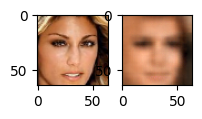

latent_loss = tensor(822.3815, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = 

 73%|███████▎  | 2506/3434 [00:44<00:24, 37.77it/s]

tensor(3.1840, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5952, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.2223, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3278, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7634, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(902.4071, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3454, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7966, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.7930, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7609, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1898, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(910.1819, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9575, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4126, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 73%|███████▎  | 2512/3434 [00:45<00:29, 31.71it/s]

latent_loss = tensor(803.2705, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2532, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6548, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.3164, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9891, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4087, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.2118, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0954, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4980, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.0095, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3037, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7232, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.6508, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6743, device='cuda:0', grad_f

 73%|███████▎  | 2521/3434 [00:45<00:30, 29.83it/s]

tensor(819.8618, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0697, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4796, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(804.3239, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1207, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5229, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.7612, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9834, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4228, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(801.5464, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0756, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4764, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.6931, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0801, device='cuda:0', grad_fn=<SumBackward

 74%|███████▍  | 2534/3434 [00:45<00:21, 41.69it/s]

latent_loss = tensor(812.7457, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1165, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5229, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.2822, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9637, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3763, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.6894, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9413, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3602, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.1379, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8919, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3065, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.0862, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8333, device='cuda:0', grad_f

 74%|███████▍  | 2549/3434 [00:45<00:16, 54.08it/s]

tensor(856.4738, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9816, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4098, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.3999, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1193, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5430, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.3365, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2216, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6683, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.6096, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9836, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4019, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.5484, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0636, device='cuda:0', grad_fn=<SumBackward

 75%|███████▍  | 2563/3434 [00:46<00:14, 58.19it/s]

latent_loss = tensor(909.1592, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8875, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3421, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(903.4331, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8610, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3127, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.4341, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1333, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5625, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.0186, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4082, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8232, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.1694, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6219, device='cuda:0', grad_f

 75%|███████▌  | 2577/3434 [00:46<00:13, 62.93it/s]

latent_loss = tensor(864.9390, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9904, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4229, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.7739, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7040, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1128, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.5857, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0088, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4071, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.9453, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0866, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4925, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(880.4039, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9462, device='cuda:0', grad_f

 75%|███████▌  | 2591/3434 [00:46<00:13, 63.07it/s]

tensor(926.4564, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2965, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7597, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.4392, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8947, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3110, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.8825, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8813, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3132, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.6613, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1190, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5613, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.2950, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8205, device='cuda:0', grad_fn=<SumBackward

 76%|███████▌  | 2606/3434 [00:46<00:12, 66.70it/s]

latent_loss = tensor(826.3961, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0600, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4732, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(808.2837, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1304, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5345, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.0391, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1596, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6011, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.2274, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0885, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5211, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(880.6296, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9803, device='cuda:0', grad_f

 76%|███████▌  | 2613/3434 [00:46<00:13, 61.71it/s]

tensor(3.4975, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.8577, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0132, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4456, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.3623, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6671, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0818, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.1757, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9657, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3688, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(762.9847, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0252, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4067, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(794.2642, device='cuda:0', grad_fn=<MulBackward0>)
reco

 76%|███████▋  | 2620/3434 [00:46<00:14, 56.01it/s]

tensor(3.2793, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(942.0251, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1686, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6396, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.6667, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0639, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4997, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.8863, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8969, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3033, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(912.3208, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0664, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5225, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(947.5679, device='cuda:0', grad_fn=<MulBackward0>)
reco

 77%|███████▋  | 2632/3434 [00:47<00:16, 50.12it/s]

latent_loss = tensor(884.4692, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0787, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5209, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.8048, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7537, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1846, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.4280, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2616, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6848, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.4438, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0023, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4110, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.3784, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9024, device='cuda:0', grad_f

 77%|███████▋  | 2644/3434 [00:47<00:15, 51.04it/s]

latent_loss = tensor(792.6158, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4278, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8241, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.4873, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8072, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2304, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.7437, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8732, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2915, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.2549, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0757, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4858, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.3887, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1091, device='cuda:0', grad_f

 77%|███████▋  | 2656/3434 [00:47<00:14, 53.02it/s]

latent_loss = tensor(824.6746, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0771, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4894, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.1388, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1397, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5673, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.0205, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1454, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5559, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.2288, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0229, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4255, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.8346, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2921, device='cuda:0', grad_f

 78%|███████▊  | 2668/3434 [00:47<00:15, 50.94it/s]

latent_loss = tensor(865.7349, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0060, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4389, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.6485, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1040, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5484, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(896.4774, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8016, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2499, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.4481, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2598, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6940, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.9616, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0531, device='cuda:0', grad_f

 78%|███████▊  | 2679/3434 [00:48<00:15, 47.58it/s]

latent_loss = tensor(828.7525, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9079, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3223, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.0754, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0668, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4723, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(818.9892, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9945, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4040, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(796.0472, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9549, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3530, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.3505, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9110, device='cuda:0', grad_f

 78%|███████▊  | 2691/3434 [00:48<00:14, 52.85it/s]

latent_loss = tensor(817.1588, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0702, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4787, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(795.9606, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0043, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4023, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.0652, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0102, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4222, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.7275, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1737, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5880, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.7068, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1736, device='cuda:0', grad_f

 79%|███████▊  | 2703/3434 [00:48<00:13, 54.39it/s]

latent_loss = tensor(868.2490, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1058, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5399, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.4606, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9595, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4103, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.7745, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9867, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4045, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.7646, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2517, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6866, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.1404, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2625, device='cuda:0', grad_f

 79%|███████▉  | 2709/3434 [00:48<00:13, 52.19it/s]

latent_loss = tensor(828.8136, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6738, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0882, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(789.7198, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7437, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1385, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.4869, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0818, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5190, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.5476, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9282, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3655, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(797.0689, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8767, device='cuda:0', grad_f

 79%|███████▉  | 2721/3434 [00:49<00:15, 47.22it/s]

latent_loss = tensor(931.6392, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8230, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2888, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.9412, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0672, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4812, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.9611, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7676, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2055, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.6793, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2385, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6798, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.7449, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7972, device='cuda:0', grad_f

 80%|███████▉  | 2731/3434 [00:49<00:15, 45.03it/s]

latent_loss = tensor(884.8000, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8625, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3049, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.6761, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1879, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6033, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.6249, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0589, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4783, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(879.5250, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1626, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6023, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.0100, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9231, device='cuda:0', grad_f

 80%|███████▉  | 2741/3434 [00:49<00:15, 45.62it/s]

latent_loss = tensor(842.2831, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9370, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3581, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.5977, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8902, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3205, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.8608, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9762, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3756, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.3914, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2584, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6956, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(792.8977, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2531, device='cuda:0', grad_f

 80%|███████▉  | 2746/3434 [00:49<00:15, 44.62it/s]

latent_loss = tensor(853.0897, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9905, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4170, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.9388, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7799, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1988, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(899.0665, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0240, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4736, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(913.2610, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2594, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7160, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.9321, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8415, device='cuda:0', grad_f

 81%|████████  | 2765/3434 [00:49<00:12, 54.86it/s]

latent_loss = tensor(856.4061, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9131, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3413, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(840.1880, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3608, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7809, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.4276, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1176, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5508, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.1496, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9876, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4007, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.1842, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.4928, device='cuda:0', grad_f

 81%|████████  | 2778/3434 [00:50<00:11, 58.87it/s]

tensor(889.9796, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9937, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4387, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(890.4095, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3814, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8266, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.8699, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2797, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7101, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(913.6891, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7753, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2322, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.1716, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8317, device='cuda:0', grad_fn=<SumBackward

 81%|████████  | 2785/3434 [00:50<00:10, 60.60it/s]

latent_loss = tensor(794.2256, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9226, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3197, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.1243, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9082, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3348, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.0812, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1506, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5771, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.3236, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1140, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5237, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.4842, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9777, device='cuda:0', grad_f

 82%|████████▏ | 2806/3434 [00:50<00:09, 64.95it/s]

latent_loss = tensor(863.3751, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2624, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6941, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(870.1633, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0967, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5318, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.2645, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8281, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2568, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.0682, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7224, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1554, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(784.6576, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1109, device='cuda:0', grad_f

 82%|████████▏ | 2820/3434 [00:50<00:09, 66.69it/s]

latent_loss = tensor(863.3987, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9533, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3850, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.4172, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8845, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3072, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(922.4393, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9797, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4409, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.9375, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9735, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4209, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.8257, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8737, device='cuda:0', grad_f

 82%|████████▏ | 2827/3434 [00:50<00:09, 65.45it/s]

latent_loss = tensor(829.2855, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0056, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4202, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(895.3492, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9500, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3977, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.1746, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1340, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5576, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.0950, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4314, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8484, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(815.3236, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9762, device='cuda:0', grad_f

 83%|████████▎ | 2842/3434 [00:51<00:09, 64.11it/s]

latent_loss = tensor(862.9297, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8421, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2736, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.7358, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1399, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5793, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(880.3165, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7317, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1719, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.7263, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8559, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3017, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.9832, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6666, device='cuda:0', grad_f

 83%|████████▎ | 2856/3434 [00:51<00:08, 64.80it/s]

latent_loss = tensor(868.9630, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0633, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4978, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(841.8091, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2660, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6869, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.7662, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0051, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4524, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.0378, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8874, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3190, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.0534, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8736, device='cuda:0', grad_f

 84%|████████▎ | 2870/3434 [00:51<00:08, 66.43it/s]

latent_loss = tensor(848.1547, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8480, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2720, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.8465, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0783, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5048, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(894.3988, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9653, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4125, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.3973, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4875, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9342, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.0238, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6658, device='cuda:0', grad_f

 84%|████████▍ | 2884/3434 [00:51<00:08, 66.55it/s]

latent_loss = tensor(803.7799, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3580, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7599, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.2179, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8496, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2752, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.6842, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1041, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5460, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.4333, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2097, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6519, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.6075, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9997, device='cuda:0', grad_f

 84%|████████▍ | 2899/3434 [00:51<00:07, 67.03it/s]

latent_loss = tensor(838.9053, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9162, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3357, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.0227, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8117, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2257, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.0122, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7308, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1688, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.2416, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0874, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5155, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.9805, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0556, device='cuda:0', grad_f

 85%|████████▍ | 2913/3434 [00:52<00:07, 65.65it/s]

tensor(3.3452, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.8303, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7842, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2261, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.9014, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8235, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2324, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(896.2245, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9879, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4360, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.9011, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8774, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2943, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(910.7079, device='cuda:0', grad_fn=<MulBackward0>)
reco

 85%|████████▌ | 2927/3434 [00:52<00:08, 61.96it/s]

latent_loss = tensor(833.0541, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9162, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3327, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(924.2284, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8488, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3109, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.5417, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0173, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4476, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(933.7977, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2621, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7290, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(782.7428, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0485, device='cuda:0', grad_f

 85%|████████▌ | 2934/3434 [00:52<00:07, 62.97it/s]

latent_loss = tensor(877.4330, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3885, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8272, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.4111, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1930, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6272, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.3005, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0167, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4504, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.4453, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8966, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3073, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(856.9955, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1223, device='cuda:0', grad_f

 86%|████████▌ | 2948/3434 [00:52<00:07, 64.31it/s]

latent_loss = tensor(837.7289, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7173, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1361, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.2361, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1194, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5230, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(864.2755, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9956, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4277, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(817.4021, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1578, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5665, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.9884, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0100, device='cuda:0', grad_f

 86%|████████▋ | 2963/3434 [00:52<00:07, 66.22it/s]

latent_loss = tensor(876.1938, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0190, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4571, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(895.1035, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2938, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7413, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(913.7200, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2621, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7189, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.8789, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1151, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5305, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.8123, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0892, device='cuda:0', grad_f

 87%|████████▋ | 2977/3434 [00:53<00:06, 66.81it/s]

latent_loss = tensor(837.7941, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0042, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4231, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.6920, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1463, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5657, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.6708, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0446, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4439, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.2013, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8545, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2876, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(791.9210, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1577, device='cuda:0', grad_f

 87%|████████▋ | 2991/3434 [00:53<00:06, 64.14it/s]

latent_loss = tensor(860.9506, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9375, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3680, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.8394, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9129, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3168, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.3303, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0200, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4432, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.0355, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0798, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5013, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.0990, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0726, device='cuda:0', grad_f

 87%|████████▋ | 2998/3434 [00:53<00:06, 65.00it/s]

latent_loss = tensor(862.5325, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9818, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4131, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.4618, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8926, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3203, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.1205, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8301, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2412, device='cuda:0', grad_fn=<AddBackward0>)


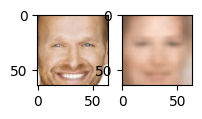

latent_loss = tensor(892.3441, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0677, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = 

 88%|████████▊ | 3005/3434 [00:53<00:10, 40.81it/s]

tensor(3.5139, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.2417, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7709, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1835, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(905.3114, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2093, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6619, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.7174, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1723, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6057, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.7803, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1311, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5625, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(890.2026, device='cuda:0', grad_fn=<MulBackward0>)
reco

 88%|████████▊ | 3011/3434 [00:54<00:13, 31.34it/s]

latent_loss = tensor(906.7296, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7553, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2086, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.1123, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0998, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5459, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.0175, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8909, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3209, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(971.0750, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0805, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5660, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(935.1600, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3021, device='cuda:0', grad_f

 88%|████████▊ | 3016/3434 [00:54<00:14, 29.14it/s]

latent_loss = tensor(845.6916, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1268, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5497, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(896.0267, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = 

 88%|████████▊ | 3020/3434 [00:54<00:14, 28.53it/s]

tensor(2.9119, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3599, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.9611, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0107, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4457, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.9995, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2800, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7225, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.0851, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1444, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5744, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.7300, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8787, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3101, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 88%|████████▊ | 3034/3434 [00:54<00:09, 42.44it/s]

latent_loss = tensor(824.4973, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0783, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4905, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.1763, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1730, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6196, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.4846, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2279, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6496, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.3261, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0919, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5195, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.8727, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9907, device='cuda:0', grad_f

 89%|████████▉ | 3048/3434 [00:54<00:07, 52.44it/s]

tensor(3.3391, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(898.7532, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8688, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3182, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.6001, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0634, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4807, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(807.4061, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0572, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4609, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(799.6226, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5425, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(2.9423, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(810.6339, device='cuda:0', grad_fn=<MulBackward0>)
reco

 89%|████████▉ | 3054/3434 [00:55<00:07, 52.71it/s]

latent_loss = tensor(826.1024, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2665, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6795, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.4456, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0092, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4329, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.0913, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1179, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5435, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(862.5267, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6820, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1133, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(944.6141, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2592, device='cuda:0', grad_f

 89%|████████▉ | 3061/3434 [00:55<00:06, 56.97it/s]

latent_loss = tensor(837.3982, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0415, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4602, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.6185, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9183, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3526, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.1527, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1005, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5180, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.5607, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0867, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5200, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 3068/3434 [00:55<00:06, 58.50it/s]

latent_loss = tensor(821.3398, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8272, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2379, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(901.1300, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9417, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3923, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.3840, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8845, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3082, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.1431, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9013, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3159, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.6259, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8701, device='cuda:0', grad_f

 90%|████████▉ | 3076/3434 [00:55<00:05, 61.38it/s]

latent_loss = tensor(852.8709, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9908, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4173, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(839.5079, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9519, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3717, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.9644, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0100, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4225, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.3042, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3916, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8287, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████▉ | 3083/3434 [00:55<00:05, 60.71it/s]

latent_loss = tensor(861.6066, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3866, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8175, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.9326, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0329, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4494, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(806.0016, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8817, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2847, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(899.5636, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0360, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4858, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.8569, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9307, device='cuda:0', grad_f

 90%|████████▉ | 3090/3434 [00:55<00:05, 61.54it/s]

latent_loss = tensor(891.0637, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0297, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4753, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.4348, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9742, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4115, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(891.9331, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7846, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2305, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 3097/3434 [00:55<00:05, 61.73it/s]

latent_loss = tensor(876.9454, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7586, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1970, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.4523, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7122, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1305, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(925.9629, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1494, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6124, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.3444, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3127, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7384, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(782.7344, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3433, device='cuda:0', grad_f

 90%|█████████ | 3104/3434 [00:55<00:05, 62.49it/s]

latent_loss = tensor(875.6304, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8402, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2780, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.1190, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1691, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5867, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(785.6282, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3976, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7904, device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 3111/3434 [00:55<00:05, 60.86it/s]

latent_loss = tensor(877.5370, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9918, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4306, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(794.0162, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1434, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5404, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.5036, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7105, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1317, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.6954, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9191, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3320, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(828.2313, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7865, device='cuda:0', grad_f

 91%|█████████ | 3125/3434 [00:56<00:04, 62.84it/s]

latent_loss = tensor(925.3235, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1616, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6242, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(844.3765, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0783, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5005, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(930.0258, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6399, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1049, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.3439, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8833, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3075, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.4156, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8184, device='cuda:0', grad_f

 91%|█████████▏| 3139/3434 [00:56<00:04, 64.82it/s]

latent_loss = tensor(826.5168, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0213, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4346, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.2589, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9313, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3499, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(811.8362, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1634, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5693, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.1666, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8426, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2677, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.6696, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9794, device='cuda:0', grad_f

 92%|█████████▏| 3153/3434 [00:56<00:04, 63.25it/s]

latent_loss = tensor(882.6073, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7093, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1506, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.4588, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0930, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4957, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.8953, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8942, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3321, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.0295, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8239, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2509, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.7457, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8616, device='cuda:0', grad_f

 92%|█████████▏| 3160/3434 [00:56<00:04, 64.03it/s]

latent_loss = tensor(816.0831, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2754, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6834, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.7803, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2255, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6649, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.3941, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3315, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7452, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(804.8207, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9225, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3249, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(798.8785, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2113, device='cuda:0', grad_f

 92%|█████████▏| 3167/3434 [00:56<00:04, 60.71it/s]

latent_loss = tensor(828.1489, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6789, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0929, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.9561, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9602, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3872, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.6760, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9578, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3836, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.9197, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3158, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7277, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.8673, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6243, device='cuda:0', grad_f

 92%|█████████▏| 3174/3434 [00:56<00:04, 63.12it/s]

latent_loss = tensor(875.7574, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9489, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3868, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.2672, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9554, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3700, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(843.9647, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0945, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5164, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(872.9289, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5297, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9661, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.8944, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7984, device='cuda:0', grad_f

 93%|█████████▎| 3181/3434 [00:57<00:03, 63.67it/s]

latent_loss = tensor(885.4578, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1058, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5485, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(787.2722, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2162, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6099, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(897.3024, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1341, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5827, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(873.1603, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7922, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2288, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.0699, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1983, device='cuda:0', grad_f

 93%|█████████▎| 3188/3434 [00:57<00:03, 64.41it/s]

latent_loss = tensor(891.1466, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0012, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4468, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(914.1252, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6871, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1442, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.8486, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9754, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4048, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(902.4904, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3412, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7925, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(907.3984, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3770, device='cuda:0', grad_f

 93%|█████████▎| 3195/3434 [00:57<00:03, 65.38it/s]

latent_loss = tensor(865.7209, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7105, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1434, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(814.0442, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9460, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3531, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.5049, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7021, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1069, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.2684, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0984, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5255, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.8940, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1086, device='cuda:0', grad_f

 93%|█████████▎| 3202/3434 [00:57<00:03, 65.68it/s]

latent_loss = tensor(832.2940, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0250, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4412, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.2358, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8328, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2794, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.6600, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6129, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0317, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.2375, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0219, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4505, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(848.1867, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1220, device='cuda:0', grad_f

 93%|█████████▎| 3209/3434 [00:57<00:03, 66.59it/s]

latent_loss = tensor(885.7494, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9966, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4395, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.7238, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9431, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3570, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(868.4821, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2485, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6828, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(842.6048, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9970, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4183, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(789.4992, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7828, device='cuda:0', grad_f

 94%|█████████▎| 3216/3434 [00:57<00:03, 63.37it/s]

latent_loss = tensor(825.3237, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9903, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4030, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.7953, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2435, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6589, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.3571, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5344, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9576, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(887.0523, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1360, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5795, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(822.4753, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0914, device='cuda:0', grad_f

 94%|█████████▍| 3223/3434 [00:57<00:03, 63.95it/s]

tensor(3.2938, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(927.3330, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0039, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4676, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(808.1546, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9862, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3903, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.2739, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8796, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2958, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.9962, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0850, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5185, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.2993, device='cuda:0', grad_fn=<MulBackward0>)
reco

 94%|█████████▍| 3230/3434 [00:57<00:03, 63.06it/s]

latent_loss = tensor(915.2620, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0886, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5463, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.1890, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2610, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6726, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.9052, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0839, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5068, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.7202, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0617, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4745, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(805.2060, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8581, device='cuda:0', grad_f

 94%|█████████▍| 3237/3434 [00:57<00:03, 62.41it/s]

latent_loss = tensor(876.3041, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3513, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7894, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.3877, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5582, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(2.9929, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.2006, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1579, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5935, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(870.9822, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2974, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7328, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.1644, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6202, device='cuda:0', grad_f

 94%|█████████▍| 3244/3434 [00:57<00:03, 62.81it/s]

tensor(3.7669, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.1737, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9241, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3567, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(852.6668, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5915, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0179, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.6337, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9346, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3444, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(816.1969, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9337, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3418, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(854.7749, device='cuda:0', grad_fn=<MulBackward0>)
reco

 95%|█████████▍| 3251/3434 [00:58<00:02, 61.55it/s]

latent_loss = tensor(873.4741, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9034, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3401, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.5333, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7810, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1968, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(837.4030, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9371, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3558, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(872.3042, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8063, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2425, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.5792, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6424, device='cuda:0', grad_f

 95%|█████████▍| 3258/3434 [00:58<00:02, 62.72it/s]

latent_loss = tensor(938.5905, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1386, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6079, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.7670, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8260, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2704, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(885.3334, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1523, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5950, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(873.0793, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6583, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0949, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(875.2562, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9389, device='cuda:0', grad_f

 95%|█████████▌| 3265/3434 [00:58<00:02, 64.22it/s]

latent_loss = tensor(877.8973, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6680, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1070, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(869.0208, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3790, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8136, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.3000, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0279, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4460, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(878.2315, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9786, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4177, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.8247, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1731, device='cuda:0', grad_f

 95%|█████████▌| 3272/3434 [00:58<00:02, 65.50it/s]

latent_loss = tensor(877.1370, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2786, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7172, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.7540, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8748, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2997, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(836.4442, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1827, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6009, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.3132, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5100, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9291, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.6241, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8113, device='cuda:0', grad_f

 95%|█████████▌| 3279/3434 [00:58<00:02, 63.45it/s]

latent_loss = tensor(820.1414, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0652, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4753, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(847.2625, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8712, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2948, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.4550, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9874, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4001, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.1363, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9545, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3736, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.9453, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2909, device='cuda:0', grad_f

 96%|█████████▌| 3286/3434 [00:58<00:02, 63.69it/s]

latent_loss = tensor(833.2820, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6634, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0800, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.4193, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0092, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4424, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.6013, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0083, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4491, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(860.9819, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7452, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1757, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.9282, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0537, device='cuda:0', grad_f

 96%|█████████▌| 3293/3434 [00:58<00:02, 64.58it/s]

latent_loss = tensor(847.9514, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7069, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1309, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(866.9850, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0636, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4971, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(838.1200, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8795, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2985, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(821.1354, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7661, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1767, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.9169, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2253, device='cuda:0', grad_f

 96%|█████████▌| 3300/3434 [00:58<00:02, 62.08it/s]

latent_loss = tensor(852.3549, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0895, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5156, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(890.6505, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0611, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5064, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.1168, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9772, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3922, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(879.4989, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9596, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3994, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(921.9725, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7193, device='cuda:0', grad_f

 96%|█████████▋| 3307/3434 [00:58<00:01, 63.73it/s]

latent_loss = tensor(884.7815, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3124, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7548, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(858.1070, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0257, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4547, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.0801, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1677, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5772, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.3029, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0850, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5231, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(872.5840, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1568, device='cuda:0', grad_f

 97%|█████████▋| 3314/3434 [00:59<00:01, 64.50it/s]

latent_loss = tensor(915.9637, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1892, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6472, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(903.1523, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0817, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5333, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.5905, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2975, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7223, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(902.5499, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1731, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6243, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.2945, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0735, device='cuda:0', grad_f

 97%|█████████▋| 3321/3434 [00:59<00:01, 65.35it/s]

latent_loss = tensor(851.3127, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2952, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.1406, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0289, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4695, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.0131, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7746, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1871, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.0244, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8561, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2726, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.7821, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6935, device='cuda:0', grad_f

 97%|█████████▋| 3328/3434 [00:59<00:01, 64.92it/s]

latent_loss = tensor(803.0787, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0648, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4663, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(845.0266, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2014, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6239, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.9763, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.5262, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.9562, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.1375, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9117, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3472, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(896.8340, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9177, device='cuda:0', grad_f

 97%|█████████▋| 3335/3434 [00:59<00:01, 65.70it/s]

latent_loss = tensor(864.1251, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7695, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2016, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.9789, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6778, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1203, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(882.2988, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1244, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5655, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(900.4219, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1392, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5894, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(884.6313, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.4379, device='cuda:0', grad_f

 97%|█████████▋| 3342/3434 [00:59<00:01, 65.72it/s]

latent_loss = tensor(862.9085, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0245, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4560, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.6724, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1730, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6138, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.5690, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7658, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1986, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(812.9806, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2253, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6318, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.6801, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9328, device='cuda:0', grad_f

 98%|█████████▊| 3349/3434 [00:59<00:01, 61.93it/s]

tensor(3.0938, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5212, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.6124, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8113, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2391, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(829.5592, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9500, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3648, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(833.7858, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9094, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3263, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(835.8443, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1957, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6136, device='cuda:0', grad_fn=<AddBackward0>)
latent_lo

 98%|█████████▊| 3356/3434 [00:59<00:01, 59.50it/s]

latent_loss = tensor(804.9845, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8467, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2492, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.7496, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8779, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2903, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(830.6354, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9857, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4010, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(865.4456, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1821, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6149, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(861.6052, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1180, device='cuda:0', grad_f

 98%|█████████▊| 3363/3434 [00:59<00:01, 51.33it/s]

latent_loss = tensor(846.7572, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8020, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2254, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(895.8387, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0151, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4631, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(827.6100, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8705, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2843, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(825.4160, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2949, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7076, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 3369/3434 [01:00<00:01, 51.30it/s]

latent_loss = tensor(833.1675, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0468, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4634, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.6851, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0804, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5267, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(831.6847, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2168, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6327, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(902.3495, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9086, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3597, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(823.0076, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7909, device='cuda:0', grad_f

 98%|█████████▊| 3375/3434 [01:00<00:01, 50.85it/s]

latent_loss = tensor(895.2761, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.3576, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.8052, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(911.1651, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0292, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4848, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(859.6213, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0556, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4854, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 3381/3434 [01:00<00:01, 48.94it/s]

latent_loss = tensor(863.5558, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9741, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4059, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(826.2361, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9734, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3865, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.3231, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9153, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3535, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(819.2821, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2490, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6586, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(809.9272, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2330, device='cuda:0', grad_f

 99%|█████████▉| 3393/3434 [01:00<00:00, 49.75it/s]

latent_loss = tensor(831.0812, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8402, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2557, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(873.4568, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9984, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4351, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(895.7573, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9616, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4094, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(892.8726, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0351, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4815, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(801.4049, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7433, device='cuda:0', grad_f

 99%|█████████▉| 3399/3434 [01:00<00:00, 49.07it/s]

latent_loss = tensor(844.2618, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1568, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.5789, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(846.3364, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6457, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.0689, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(820.2371, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0161, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4262, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(824.3945, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8979, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3101, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(853.6725, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.1793, device='cuda:0', grad_f

 99%|█████████▉| 3405/3434 [01:00<00:00, 51.48it/s]

latent_loss = tensor(885.9922, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8504, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2934, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(855.0710, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8654, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2930, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(935.8064, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8527, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3206, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(857.6801, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9634, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3922, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████▉| 3411/3434 [01:00<00:00, 50.54it/s]

latent_loss = tensor(875.5854, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8576, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2954, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(851.7008, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.5606, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(2.9865, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(850.1795, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7866, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2117, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(849.6126, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8213, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2462, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(888.3810, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9541, device='cuda:0', grad_f

100%|█████████▉| 3417/3434 [01:01<00:00, 50.95it/s]

latent_loss = tensor(831.8259, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.7674, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1833, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(910.6423, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2255, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6808, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(889.0843, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9460, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3905, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(904.8274, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0019, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4543, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(834.3860, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0495, device='cuda:0', grad_f

100%|█████████▉| 3423/3434 [01:01<00:00, 52.92it/s]

latent_loss = tensor(833.4271, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8182, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2349, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(871.7390, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8515, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.2874, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(832.7229, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8925, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3089, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(867.4555, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2101, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6438, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(893.7626, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0904, device='cuda:0', grad_f

100%|█████████▉| 3429/3434 [01:01<00:00, 53.69it/s]

latent_loss = tensor(821.8060, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0295, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4404, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(877.7853, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2780, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.7169, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(881.0502, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.6991, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.1396, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(863.2268, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9342, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3658, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = 

100%|██████████| 3434/3434 [01:01<00:00, 55.98it/s]

tensor(922.3183, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.2087, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.6699, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(874.9536, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.9290, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3665, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(876.3036, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(3.0182, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.4564, device='cuda:0', grad_fn=<AddBackward0>)
latent_loss = tensor(883.7675, device='cuda:0', grad_fn=<MulBackward0>)
reconstruction_loss = tensor(2.8726, device='cuda:0', grad_fn=<SumBackward0>)
vae_loss = tensor(3.3145, device='cuda:0', grad_fn=<AddBackward0>)



COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : splendid_gorilla_3491
COMET INFO:     url                   : https://www.comet.com/sathikaranathunga/6s191-lab2-part2-dbvae/249840f028f24c95ac57281acb3ed9d9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (2.813838481903076, 18.738723754882812)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1BU6keEhG2dWYL-Gh35v8QKi8T2170I7n
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     latent_dim    : 100
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     f

In [40]:
### Training the DB-VAE ###

# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=2,  # DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# Instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"]).to(device)
optimizer = optim.Adam(dbvae.parameters(), lr=params["learning_rate"])

# Define the training step
def debiasing_train_step(x, y):
    optimizer.zero_grad()
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    # call the DB-VAE loss function with correct arguments
    loss, class_loss = debiasing_loss_function(
        x, x_recon, y, y_logit, z_mean, z_logsigma #Corrected the order of x and y
    )

    loss.backward()
    optimizer.step()
    return loss

# Get training faces from data loader
all_faces = loader.get_all_train_faces()

# Training loop
step = 0
for i in range(params["num_epochs"]):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, params["num_epochs"]))

    # Recompute sampling probabilities for debiasing
    # Pass 'all_faces' as the first argument, not 'dbvae'
    p_faces = get_training_sample_probabilities(all_faces, dbvae)

# Inner loop
    for j in tqdm.tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Load a batch of data
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        # Perform training step
        loss = debiasing_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()

        experiment.log_metric("loss", loss_value, step=step)

        # Plot progress every 500 steps
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae, backend="pt")

        step += 1

experiment.end()


#6 Evaluation of DB-VAE on Test Dataset

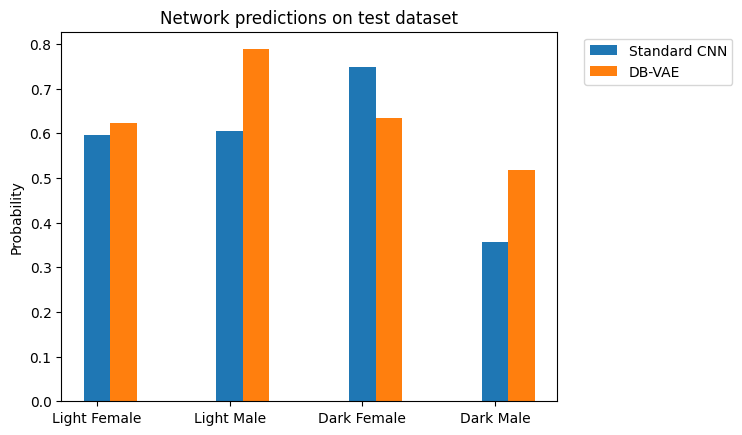

In [42]:

dbvae.to(device)
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to(device)
    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)
        dbvae_logits_list.append(logit.detach().cpu().numpy())
dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()
xx = np.arange(len(keys))
std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)
plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")
plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()
